In [260]:
# 2022-10-17 10:30 Понед Фр
# Анализ и прогнозирование временного ряда стоимости уля.
# На Основе Project_01_Commodity/TS_commodity_14.ipynb. Пересчет в золото и нефть, Корреляция. Шкалирование. 
# Логарифм.изм. дневных стоймостей угля в разн ед.изм.
# ARIMA. Прогноз на основе ARIMA. Прогоноз получился, но очень примитивный. TS_Coal_01.ipynb

# 2022-10-18 10:25 Фр TS_Coal_02.ipynb. Изменил деление при расчете в золоте и нефти
# Добавляю сглажив и эспоненц сглаж.
# Начал sktime

# 2022-10-19 10:20 Фр TS_Coal_03.ipynb.

###### Start


# Оглавление / Краткое содержание

### 00. Введение

### 01. [Загрузка библиотек](######Library)

### 02. [Загрузка данных](######DataFrame)

### 03. [Соединение все представленных временных рядов в один dateframe](######df)


#### 03.1 [Корреляция временных рядов](######corr)
#### 03.2 [Ежедневная волотильность временных рядов](######df_corr)

### 04. [Шкалирование временных рядов](######df1_scaler) 


### 05. [Перход к измерению в унциях золота](######df_gold)
#### 05.1 [Корреляция временных рядов выраженная в унциях золота](######corr_gold)


### 06. [Перход к измерению в баррелях нефти](######df_brent)
#### 06.1 [Корреляция временных рядов выраженная в баррелях нефти](######corr_brent)

### 07. [Представление шкалированной стоимости угля в разных ед.измерения](######df2)
#### 07.1 [Корреляция стоимости угля выраженная в разных единицах измеренния](######corr2)

### 08. [Прогноз стоимости угля на основе ARIMA](######df3)
#### 08.1 [Графики автокорреляции и частичной автокорреляции шкалированной стоимости угля](######acf)
#### 08.2 [Графики компоненты: тренд, сезонность и шум](######sm.tsa.seasonal_decompose)
#### 08.3 [Подбор параметров для модели временных рядов ARIMA для прогнозирования стоимости угля в $](######sm.tsa.statespace.SARIMAX)
#### 08.4 [Обучение модели временных рядов ARIMA для стоимости угля в $](######mod.fit)


### [09 Построение прогнозов стоимости угля на основании использования библиотеки SKTIME](######sktime)
#### 09.1 [Метод прогнозирования VAR](######sktime.var)
#### 09.2 [Метод прогнозирования ARIMA](######sktime.arima)





[Ссылка на окончание](####Finish)



## 00. Введение / Краткое содержание

В данном файле представлен анализ временого ряда стоимости угля.

Во второй части произведено прогнозирование стоимости угля с использованием библиотек на языке Python статистического анализа, глубокого обучения и нейроных сетей 


## 01. Загрузка библиотек
###### Library

[Ссылка в начало](######Start)

In [261]:
#  Загрузка необходимых библиотек Python

import numpy as np
import pandas as pd
import pandas_datareader as pdr

import matplotlib.pyplot as plt
from matplotlib import pyplot

from pandas.plotting import scatter_matrix

import seaborn as sns

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import normalize


#for ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.api as sm

from pylab import rcParams

import itertools

import warnings

from scipy.stats import pearsonr, spearmanr

# sktime
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

from sktime.datasets import load_longley
from sktime.forecasting.var import VAR

from sktime.forecasting.varmax import VARMAX

from sktime.registry import all_estimators

from sktime.datasets import load_longley
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter


from sktime.forecasting.theta import ThetaForecaster

from sktime.utils import plotting

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series


In [262]:
# Задание параметров вывода 
# Формат чисел
# pd.option_context('display.float_format', '{:0.20f}'.format)
pd.set_option("display.precision", 5)

pd.set_option('display.max_columns', 25)
# pd.set_option('display.max_rows', 15)


<div style="page-break-after: always;"></div>

## 02. Загрузка данных
###### DateFrame

[Ссылка на оглавление](######Start)


Загружаем данные с https://finance.yahoo.com/, сразу получаем представление в графике и строим datagrame по цене закрытия. 

Дату начала анализа временных рядов принял за 1 января 2015 года.

In [263]:
# Задание дата начала выборки данных. 

start='2008-01-01'

start

'2008-01-01'

### Уголь $ за тонну
###### MTF=F
Coal (API2) CIF ARA (ARGUS-McCl (MTF=F)

<a href="https://finance.yahoo.com/quote/MTF=F?p=MTF=F" target="_blank">https://finance.yahoo.com/quote/MTF=F?p=MTF=F</a>

[Ссылка на оглавление](######Start)

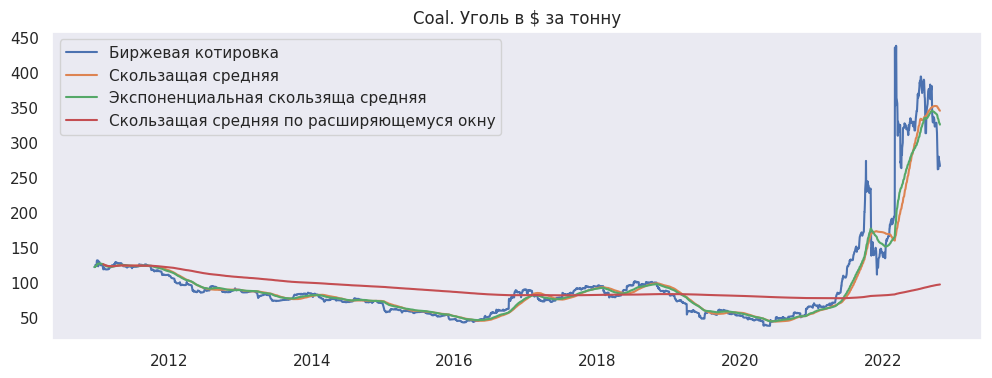

In [264]:
# уголь
mtff = pdr.get_data_yahoo('MTF=F', start=start)

print(mtff.tail())
print('-----')
print(len(mtff['Close']))

plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(mtff['Close'], label='Биржевая котировка')
plt.plot(mtff['Close'].rolling(90, min_periods=30).mean(), label='Скользащая средняя')
plt.plot(mtff['Close'].ewm(span=90).mean(), label='Экспоненциальная скользяща средняя')
plt.plot(mtff['Close'].expanding(30).mean(), label='Скользащая средняя по расширяющемуся окну')
plt.title('Coal. Уголь в $ за тонну')
plt.legend()
plt.show()


In [265]:
# для сверки: ценообразование Воркутыуголь котировок High Vol A (East Coast USA, FOB) 
# cент 21: 341
# окт. 21: 386
# и для сравнения корировки с yahoo.finance

mtff['2021-09-01':'2021-09-30']['Close'].mean(), mtff['2021-10-01':'2021-10-31']['Close'].mean()

(176.31904820033483, 238.269047328404)

<AxesSubplot: xlabel='Date'>

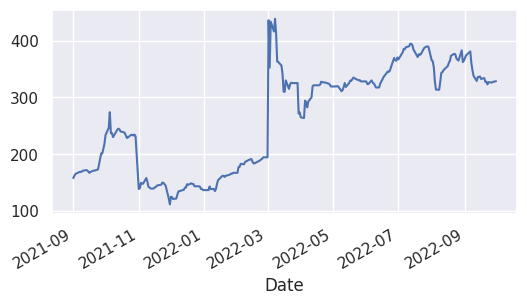

In [266]:
mtff['2021-09-01':'2022-09-30']['Close'].plot(figsize=(6, 3))

In [267]:
# беру только цену закрытия
coal = mtff['Close'].to_frame(name='Coal')

coal

Coal
Date                 
2010-12-17  122.50000
2010-12-20  122.50000
2010-12-21  123.25000
2010-12-22  125.50000
2010-12-23  125.25000
...               ...
2022-10-12  280.00000
2022-10-13  273.50000
2022-10-14  274.50000
2022-10-17  269.50000
2022-10-18  266.64999

[2868 rows x 1 columns]

### Нефть $ за баррель
###### BZ=F

<a href="https://finance.yahoo.com/quote/BZ=F?p=BZ=F" target="_blank">https://finance.yahoo.com/quote/BZ=F?p=BZ=F</a>

[Ссылка на оглавление](######Start)

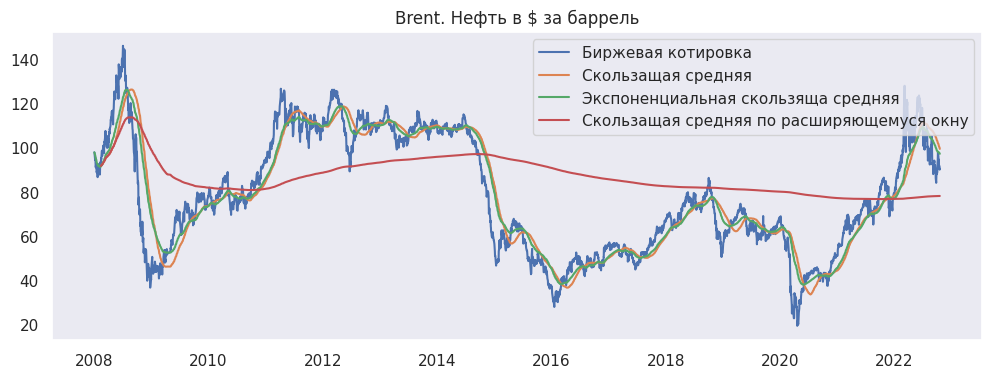

In [268]:
# нефть
bzf = pdr.get_data_yahoo('BZ=F', start=start)

print(bzf.tail())
print('-----')
print(len(bzf['Close']))

plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(bzf['Close'], label='Биржевая котировка')
plt.plot(bzf['Close'].rolling(90, min_periods=30).mean(), label='Скользащая средняя')
plt.plot(bzf['Close'].ewm(span=90).mean(), label='Экспоненциальная скользяща средняя')
plt.plot(bzf['Close'].expanding(30).mean(), label='Скользащая средняя по расширяющемуся окну')
plt.title('Brent. Нефть в $ за баррель')
plt.legend()
plt.show()

In [269]:
# беру только цену закрытия
brent = bzf['Close'].to_frame(name='Brent')

brent

Brent
Date             
2008-01-02  97.84
2008-01-03  97.60
2008-01-04  96.79
2008-01-07  94.39
2008-01-08  95.54
...           ...
2022-10-13  94.57
2022-10-14  91.63
2022-10-17  91.62
2022-10-18  90.03
2022-10-19  90.47

[3669 rows x 1 columns]

### Золото $ за тройскую унцию
###### GC=F

<a href="https://finance.yahoo.com/quote/GC=F?p=GC=F" target="_blank">https://finance.yahoo.com/quote/GC=F?p=GC=F</a>

[Ссылка на оглавление](######Start)

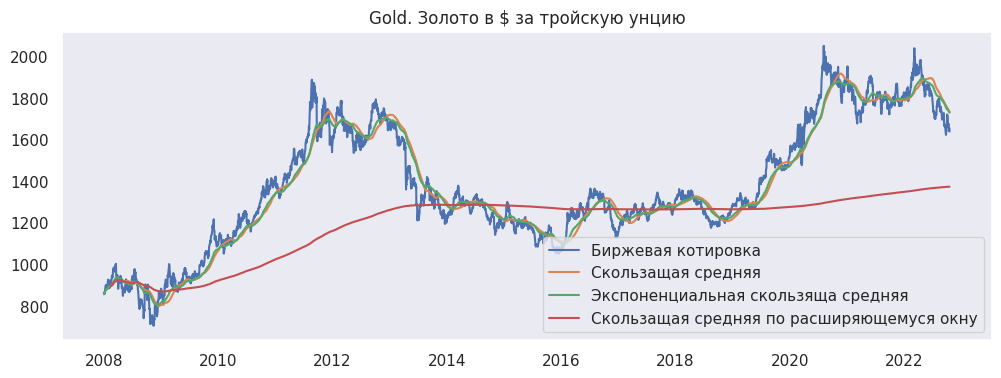

In [270]:
# золото
gcf = pdr.get_data_yahoo('GC=F', start=start)

print(gcf.tail())
print('-----')
print(len(gcf['Close']))

plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(gcf['Close'], label='Биржевая котировка')
plt.plot(gcf['Close'].rolling(90, min_periods=30).mean(), label='Скользащая средняя')
plt.plot(gcf['Close'].ewm(span=90).mean(), label='Экспоненциальная скользяща средняя')
plt.plot(gcf['Close'].expanding(30).mean(), label='Скользащая средняя по расширяющемуся окну')
plt.title('Gold. Золото в $ за тройскую унцию')
plt.legend()
plt.show()

In [271]:
# беру только цену закрытия
gold = gcf['Close'].to_frame(name='Gold')


gold

Gold
Date                  
2008-01-02   857.00000
2008-01-03   866.40002
2008-01-04   863.09998
2008-01-07   859.59998
2008-01-08   878.00000
...                ...
2022-10-13  1670.00000
2022-10-14  1641.69995
2022-10-17  1657.00000
2022-10-18  1649.00000
2022-10-19  1639.30005

[3725 rows x 1 columns]

### Серебро $ за тройскую унцию
###### SI=F
<a href="https://finance.yahoo.com/quote/SI=F?p=SI=F" target="_blank">https://finance.yahoo.com/quote/SI=F?p=SI=F</a>

[Ссылка на оглавление](######Start)

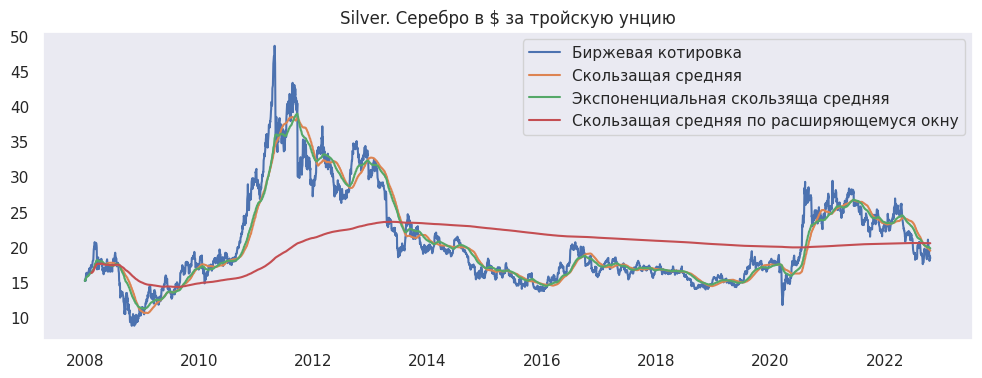

In [272]:
# серебро
sif = pdr.get_data_yahoo('SI=F', start=start)

print(sif.tail())
print('-----')
print(len(sif['Close']))

plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(sif['Close'], label='Биржевая котировка')
plt.plot(sif['Close'].rolling(90, min_periods=30).mean(), label='Скользащая средняя')
plt.plot(sif['Close'].ewm(span=90).mean(), label='Экспоненциальная скользяща средняя')
plt.plot(sif['Close'].expanding(30).mean(), label='Скользащая средняя по расширяющемуся окну')
plt.title('Silver. Серебро в $ за тройскую унцию')
plt.legend()
plt.show()

In [273]:
# беру только цену закрытия
silver = sif['Close'].to_frame(name='Silver')

silver

Silver
Date              
2008-01-02  15.167
2008-01-03  15.382
2008-01-04  15.346
2008-01-07  15.180
2008-01-08  15.707
...            ...
2022-10-13  18.858
2022-10-14  18.015
2022-10-17  18.674
2022-10-18  18.571
2022-10-19  18.395

[3724 rows x 1 columns]

### Платина $ за тройскую унцию
###### PL=F

<a href="https://finance.yahoo.com/quote/PL=F?p=PL=F" target="_blank">https://finance.yahoo.com/quote/PL=F?p=PL=F</a>

[Ссылка на оглавление](######Start)

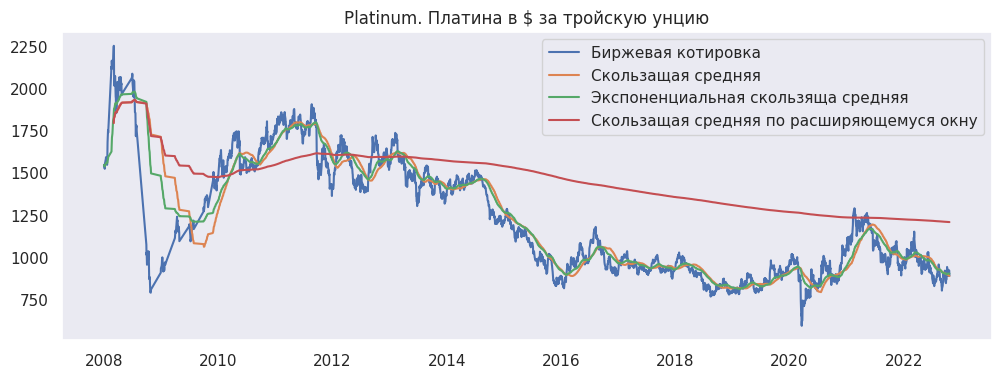

In [274]:
# Platinum
plf = pdr.get_data_yahoo('PL=F', start=start)

print(plf.tail())
print('-----')
print(len(plf['Close']))


plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(plf['Close'], label='Биржевая котировка')
plt.plot(plf['Close'].rolling(90, min_periods=30).mean(), label='Скользащая средняя')
plt.plot(plf['Close'].ewm(span=90).mean(), label='Экспоненциальная скользяща средняя')
plt.plot(plf['Close'].expanding(30).mean(), label='Скользащая средняя по расширяющемуся окну')
plt.title('Platinum. Платина в $ за тройскую унцию')
plt.legend()
plt.show()

In [275]:
# беру только цену закрытия
platinum = plf['Close'].to_frame(name='Platinum')

platinum

Platinum
Date                  
2008-01-02  1547.00000
2008-01-03  1541.80005
2008-01-04  1539.09998
2008-01-07  1524.19995
2008-01-08  1553.59998
...                ...
2022-10-13   906.79999
2022-10-14   905.29999
2022-10-17   924.00000
2022-10-18   917.70001
2022-10-19   891.50000

[3425 rows x 1 columns]

### Натуральный газ (в долларах ($) на единицу MMBtu(1 млн БТЕ) (1 Btu ≈ 1054,615 Дж)
###### NG=F
<a href="https://finance.yahoo.com/quote/NG=F?p=NG=F" target="_blank">https://finance.yahoo.com/quote/NG=F?p=NG=F</a>

[Ссылка на оглавление](######Start)

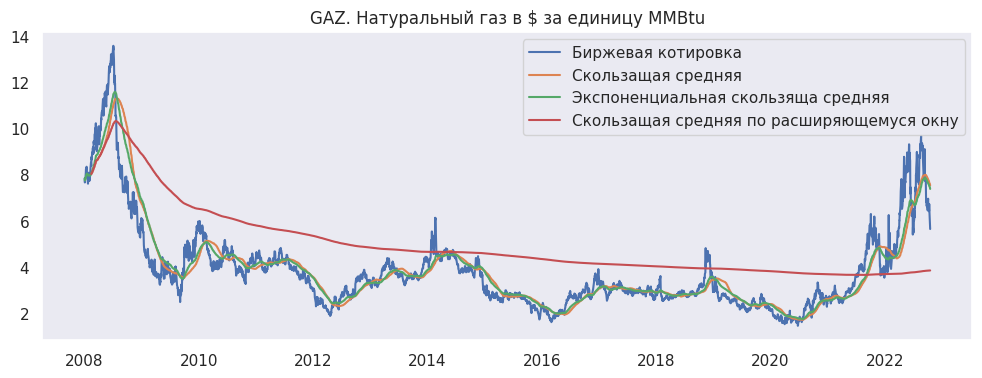

In [276]:
# газ
ngf = pdr.get_data_yahoo('NG=F', start=start)

print(ngf.tail())
print('-----')
print(len(ngf['Close']))

plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(ngf['Close'], label='Биржевая котировка')
plt.plot(ngf['Close'].rolling(90, min_periods=30).mean(), label='Скользащая средняя')
plt.plot(ngf['Close'].ewm(span=90).mean(), label='Экспоненциальная скользяща средняя')
plt.plot(ngf['Close'].expanding(30).mean(), label='Скользащая средняя по расширяющемуся окну')
plt.title('GAZ. Натуральный газ в $ за единицу MMBtu')
plt.legend()
plt.show()

In [277]:
# беру только цену закрытия
gaz = ngf['Close'].to_frame(name='Gaz')

gaz

Gaz
Date             
2008-01-02  7.850
2008-01-03  7.674
2008-01-04  7.841
2008-01-07  7.879
2008-01-08  7.967
...           ...
2022-10-13  6.741
2022-10-14  6.453
2022-10-17  5.999
2022-10-18  5.745
2022-10-19  5.663

[3727 rows x 1 columns]

### Алюминий $ за тонну
###### ALI=F
<a href="https://finance.yahoo.com/quote/ALI=F?p=ALI=F" target="_blank">https://finance.yahoo.com/quote/ALI=F?p=ALI=F</a>

[Ссылка на оглавление](######Start)

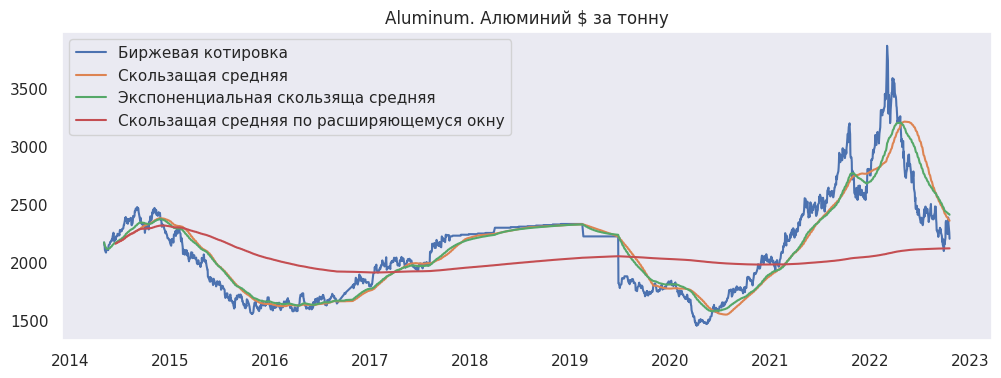

In [278]:
# Aluminum 
ali = pdr.get_data_yahoo('ALI=F', start=start)

print(ali.tail())
print('-----')
print(len(ali['Close']))

plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(ali['Close'], label='Биржевая котировка')
plt.plot(ali['Close'].rolling(90, min_periods=30).mean(), label='Скользащая средняя')
plt.plot(ali['Close'].ewm(span=90).mean(), label='Экспоненциальная скользяща средняя')
plt.plot(ali['Close'].expanding(30).mean(), label='Скользащая средняя по расширяющемуся окну')
plt.title('Aluminum. Алюминий $ за тонну')
plt.legend()
plt.show()

In [279]:
# беру только цену закрытия
aluminum = ali['Close'].to_frame(name='Aluminum')

aluminum

Aluminum
Date                
2014-05-06   2172.75
2014-05-07   2149.00
2014-05-08   2141.75
2014-05-09   2107.25
2014-05-12   2088.25
...              ...
2022-10-12   2312.25
2022-10-13   2388.00
2022-10-14   2337.75
2022-10-17   2259.75
2022-10-18   2204.50

[2092 rows x 1 columns]

### Медь $ за фунт
###### HG=F
<a href="https://finance.yahoo.com/quote/HG%3DF?p=HG%3DF" target="_blank">https://finance.yahoo.com/quote/HG%3DF?p=HG%3DF</a>

[Ссылка на оглавление](######Start)

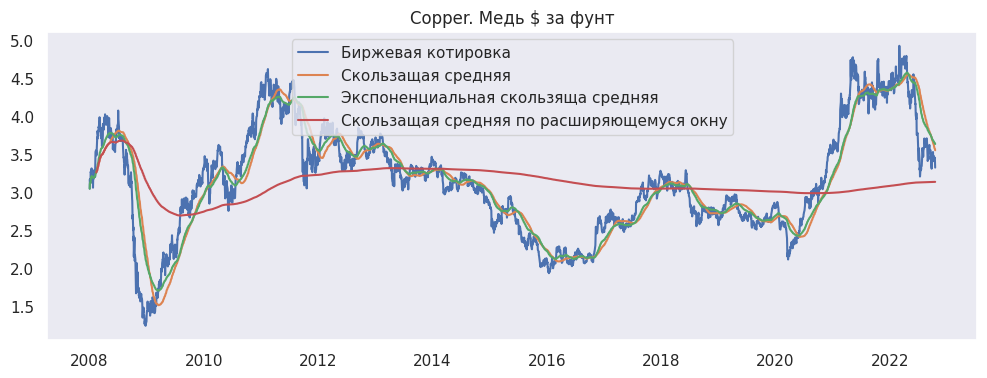

In [280]:
# Copper
hgf = pdr.get_data_yahoo('HG=F', start=start)

print(hgf.tail())
print('-----')
print(len(hgf['Close']))

plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(hgf['Close'], label='Биржевая котировка')
plt.plot(hgf['Close'].rolling(90, min_periods=30).mean(), label='Скользащая средняя')
plt.plot(hgf['Close'].ewm(span=90).mean(), label='Экспоненциальная скользяща средняя')
plt.plot(hgf['Close'].expanding(30).mean(), label='Скользащая средняя по расширяющемуся окну')
plt.title('Copper. Медь $ за фунт')
plt.legend()
plt.show()

In [281]:
# беру только цену закрытия
cupper = hgf['Close'].to_frame(name='Cupper')

cupper

Cupper
Date              
2008-01-02  3.0505
2008-01-03  3.1730
2008-01-04  3.1415
2008-01-07  3.1250
2008-01-08  3.2735
...            ...
2022-10-13  3.4675
2022-10-14  3.4505
2022-10-17  3.4555
2022-10-18  3.4065
2022-10-19  3.3280

[3726 rows x 1 columns]

### S&P-GSCI Commodity Index Future - показателем динамики сырьевых товаров
###### GD=F

<a href="https://finance.yahoo.com/quote/GD%3DF?p=GD%3DF" target="_blank">https://finance.yahoo.com/quote/GD%3DF?p=GD%3DF</a>

[Ссылка на оглавление](######Start)

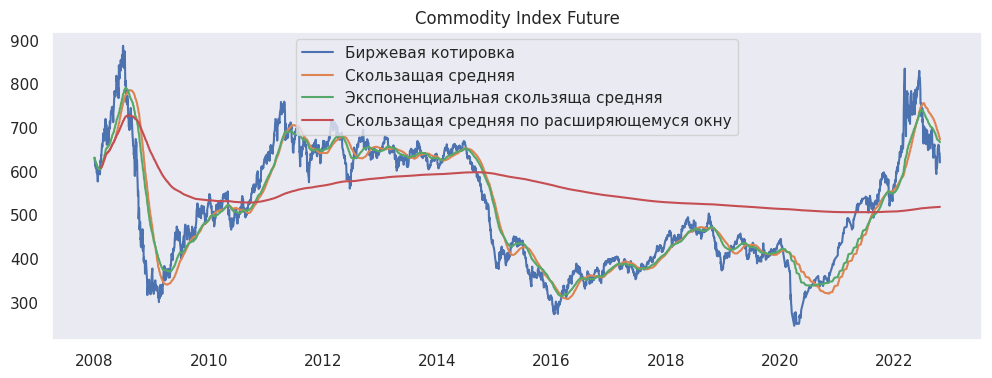

In [282]:
# Commodity Index Future
gdf = pdr.get_data_yahoo('GD=F', start=start)

print(gdf.tail())
print('-----')
print(len(gdf['Close']))

plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(gdf['Close'], label='Биржевая котировка')
plt.plot(gdf['Close'].rolling(90, min_periods=30).mean(), label='Скользащая средняя')
plt.plot(gdf['Close'].ewm(span=90).mean(), label='Экспоненциальная скользяща средняя')
plt.plot(gdf['Close'].expanding(30).mean(), label='Скользащая средняя по расширяющемуся окну')
plt.title('Commodity Index Future')
plt.legend()
plt.show()

In [283]:
# беру только цену закрытия
CIF = gdf['Close'].to_frame(name='CIF')

CIF

CIF
Date                 
2008-01-02  630.50000
2008-01-03  630.50000
2008-01-04  624.79999
2008-01-07  612.00000
2008-01-08  621.25000
...               ...
2022-10-13  657.65002
2022-10-14  642.59998
2022-10-17  640.71997
2022-10-18  627.79999
2022-10-19  619.84998

[3543 rows x 1 columns]

### Зерно $ за 1 тонну
###### ZC=F

<a href="https://finance.yahoo.com/quote/ZC=F?p=ZC=F" target="_blank">https://finance.yahoo.com/quote/ZC=F?p=ZC=F</a>

[Ссылка на оглавление](######Start)

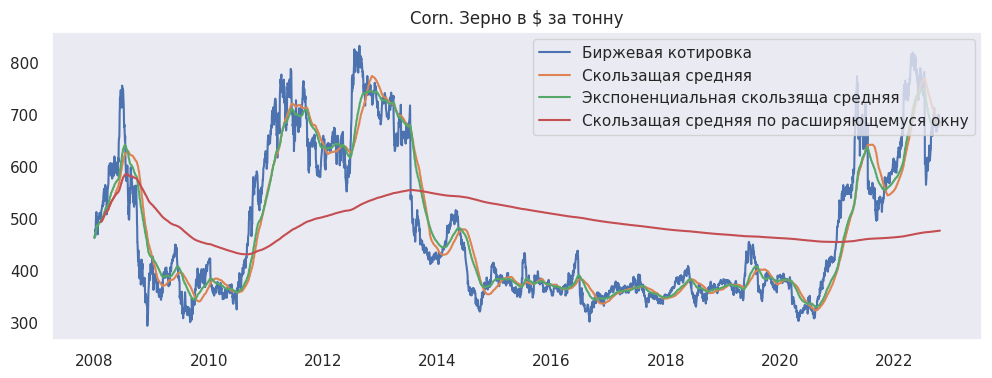

In [284]:
# Corn
zcf = pdr.get_data_yahoo('ZC=F', start=start)

print(zcf.tail())
print('-----')
print(len(zcf['Close']))

plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(zcf['Close'], label='Биржевая котировка')
plt.plot(zcf['Close'].rolling(90, min_periods=30).mean(), label='Скользащая средняя')
plt.plot(zcf['Close'].ewm(span=90).mean(), label='Экспоненциальная скользяща средняя')
plt.plot(zcf['Close'].expanding(30).mean(), label='Скользащая средняя по расширяющемуся окну')
plt.title('Corn. Зерно в $ за тонну')
plt.legend()
plt.show()

In [285]:
# беру только цену закрытия
corn = zcf['Close'].to_frame(name='Corn')

## 03. Соединение все представленных временных рядов в один dateframe
###### df

[Ссылка на оглавление](######Start)

In [286]:
# соединение всех данных в один df

df = pd.concat([coal, brent, gaz, CIF, cupper, aluminum, corn, gold, silver, platinum], axis=1)

# удаление nan

df = df.dropna(how='any')

# перечень столбцов
col = df.columns


df

Coal   Brent    Gaz        CIF  Cupper  Aluminum    Corn  \
Date                                                                        
2014-05-06   75.15000  107.06  4.799  649.00000  3.0750   2172.75  513.00   
2014-05-07   74.85000  108.13  4.740  652.20001  3.0505   2149.00  510.25   
2014-05-08   75.15000  108.04  4.572  650.75000  3.0825   2141.75  513.25   
2014-05-09   75.15000  107.89  4.531  648.50000  3.1005   2107.25  505.00   
2014-05-12   75.10000  108.41  4.434  650.00000  3.1665   2088.25  497.50   
...               ...     ...    ...        ...     ...       ...     ...   
2022-10-12  280.00000   92.45  6.435  649.25000  3.4445   2312.25  693.00   
2022-10-13  273.50000   94.57  6.741  657.65002  3.4675   2388.00  697.75   
2022-10-14  274.50000   91.63  6.453  642.59998  3.4505   2337.75  689.75   
2022-10-17  269.50000   91.62  5.999  640.71997  3.4555   2259.75  683.50   
2022-10-18  266.64999   90.03  5.745  627.79999  3.4065   2204.50  681.00   

                  Gold  Silver    Platinum  
Date                                        
2014-05-06  1308.30005  19.598  1457.09998  
2014-05-07  1288.59998  19.298  1433.80005  
2014-05-08  1287.40002  19.094  1437.09998  
2014-05-09  1287.30005  19.077  1428.90002  
2014-05-12  1295.59998  19.500  1440.90002  
...                ...     ...         ...  
2022-10-12  1670.30005  18.878   891.40002  
2022-10-13  1670.00000  18.858   906.79999  
2022-10-14  1641.69995  18.015   905.29999  
2022-10-17  1657.00000  18.674   924.00000  
2022-10-18  1649.00000  18.571   917.70001  

[1838 rows x 10 columns]

In [287]:
# сохранил в excel что бы было.
# df.to_excel('ts_base_coal_1.xlsx')

In [288]:
# сводные статистики

df.describe()

Coal       Brent         Gaz         CIF      Cupper    Aluminum  \
count  1838.00000  1838.00000  1838.00000  1838.00000  1838.00000  1838.00000   
mean    101.76013    66.48324     3.37423   457.43210     3.01981  2147.94600   
std      80.58190    20.29600     1.48025   114.86628     0.69531   408.85534   
min      38.58000    22.76000     1.55200   245.89999     1.93950  1452.00000   
25%      57.86250    51.65250     2.59425   381.43749     2.59813  1808.62500   
50%      75.05000    63.27000     2.89100   423.64999     2.81775  2209.50000   
75%      95.13750    75.90250     3.76175   520.08752     3.18837  2328.25000   
max     438.35001   127.98000     9.68000   834.50000     4.92900  3873.00000   

             Corn        Gold      Silver    Platinum  
count  1838.00000  1838.00000  1838.00000  1838.00000  
mean    428.43553  1415.58226    18.22658   987.06474  
std     120.23351   257.80036     3.49059   154.44586  
min     301.50000  1050.80005    12.77200   656.70001  
25%     358.75000  1226.50000    15.81925   888.14998  
50%     374.75000  1296.20001    17.04350   953.35001  
75%     427.62500  1682.82495    19.62400  1033.57501  
max     818.25000  2051.50000    29.39800  1516.00000

In [289]:
# Графики (но не совсем наглядно и приемлемо)
# df.plot(kind='line', subplots=True, figsize=(10, 16));


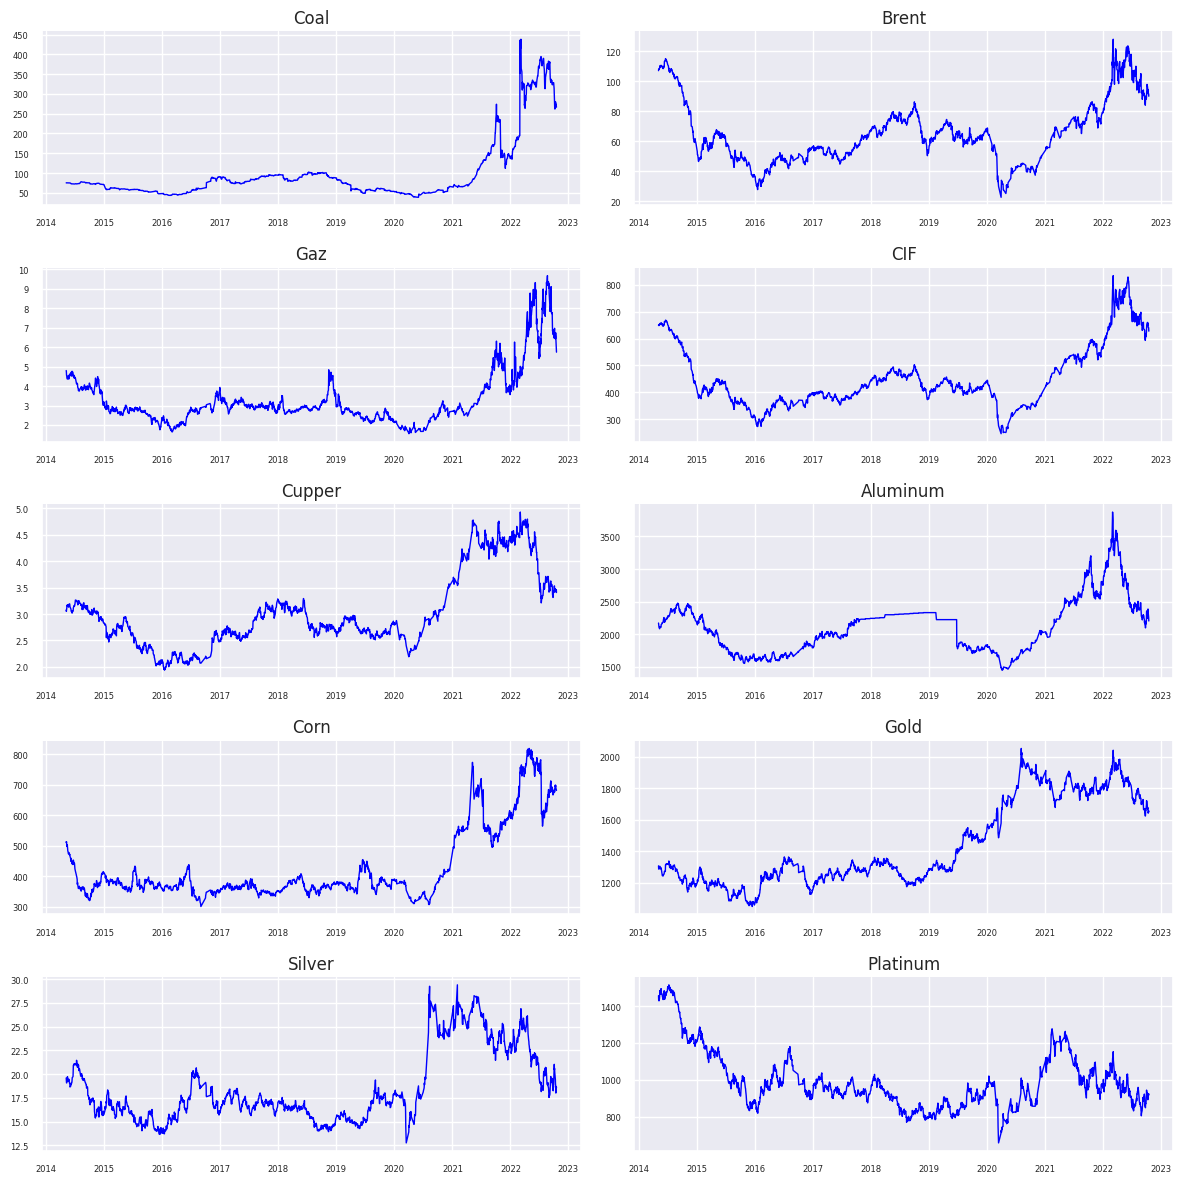

In [290]:
# графики 
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=100, figsize=(12,12)) 
for i, ax in enumerate(axes.flatten()):
    data_temp = df[df.columns[i]]
    ax.plot(data_temp, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.grid(1)

plt.tight_layout();

### 03.1 Корреляция временных рядов
###### corr

[Ссылка на оглавление](######Start)

In [291]:
# Корреляция 
corr = df.corr()
corr

Coal    Brent      Gaz      CIF   Cupper  Aluminum     Corn  \
Coal      1.00000  0.69223  0.89996  0.80054  0.65494   0.66417  0.82595   
Brent     0.69223  1.00000  0.75020  0.96849  0.67215   0.75753  0.64340   
Gaz       0.89996  0.75020  1.00000  0.83879  0.62334   0.63193  0.75387   
CIF       0.80054  0.96849  0.83879  1.00000  0.78074   0.80331  0.79376   
Cupper    0.65494  0.67215  0.62334  0.78074  1.00000   0.86056  0.81089   
Aluminum  0.66417  0.75753  0.63193  0.80331  0.86056   1.00000  0.67326   
Corn      0.82595  0.64340  0.75387  0.79376  0.81089   0.67326  1.00000   
Gold      0.57369  0.36556  0.46992  0.51426  0.76656   0.49495  0.73597   
Silver    0.41595  0.36884  0.39304  0.51169  0.78576   0.50696  0.66487   
Platinum -0.09017  0.34677  0.10552  0.33009  0.20230   0.14911  0.07855   

             Gold   Silver  Platinum  
Coal      0.57369  0.41595  -0.09017  
Brent     0.36556  0.36884   0.34677  
Gaz       0.46992  0.39304   0.10552  
CIF       0.51426  0.51169   0.33009  
Cupper    0.76656  0.78576   0.20230  
Aluminum  0.49495  0.50696   0.14911  
Corn      0.73597  0.66487   0.07855  
Gold      1.00000  0.84894  -0.03267  
Silver    0.84894  1.00000   0.35578  
Platinum -0.03267  0.35578   1.00000

Text(0.5, 1.0, 'Корреляция ежедневных значений в $')

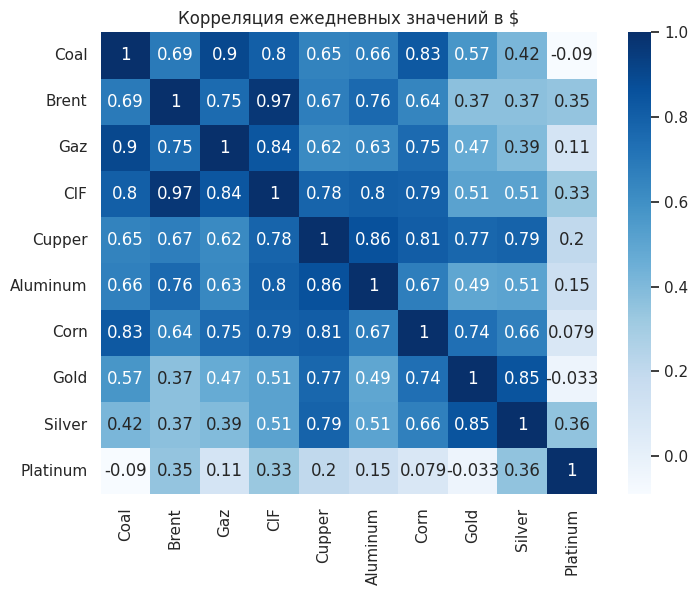

In [292]:
# Корреляция график heatmap

sns.set(rc = {'figure.figsize':(8, 6)})


sns.heatmap(corr, cmap='Blues', annot=True).set_title('Корреляция ежедневных значений в $')

In [293]:
# Определяем корреляцию Пирсона
# Коэффициент корреляции Пирсона применяется для исследования взаимосвязи двух переменных, 
# измеренных в метрических шкалах на одной и той же выборке. 
# Он позволяет определить, насколько пропорциональная изменчивость двух переменных.


pearsonr(df['Brent'], df['Coal'])

(0.6922300797949152, 2.2222981887035758e-262)

In [294]:
pearsonr(df['Brent'], df['CIF'])

(0.9684904615374563, 0.0)

In [295]:
# Коэфт корреляциии Спирмена
# Коэффициент корреляции Спирмена определяется как коэффициент корреляции Пирсона между ранговыми переменными.

spearmanr(df['Brent'], df['Coal'])

SpearmanrResult(correlation=0.7004179224688545, pvalue=3.2808104727814977e-271)

In [296]:
spearmanr(df['Brent'], df['CIF'])

SpearmanrResult(correlation=0.9823740375589435, pvalue=0.0)

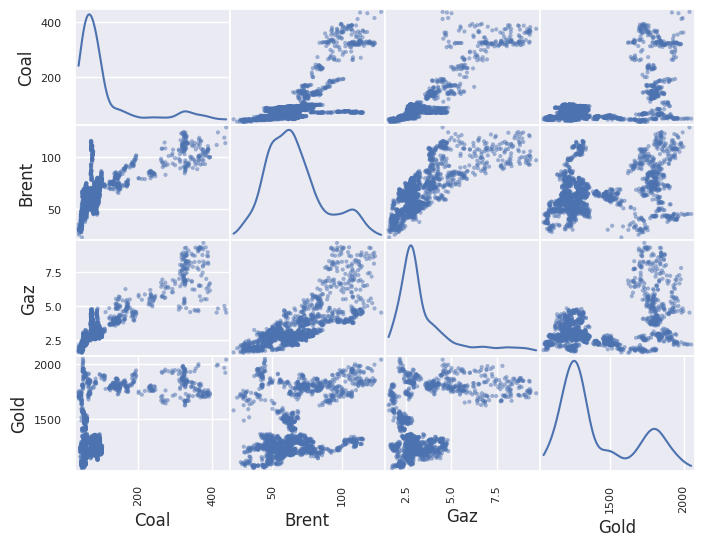

In [297]:
# Корреляция график scatter_matrix по отдельным временным рядам

df1 = df[["Coal", 'Brent', "Gaz", 'Gold']]

print(df1.corr())
pd.plotting.scatter_matrix(df1, diagonal='kde'); # , diagonal='kde'

### 03.2 Ежедневная волотильность временных рядов
###### df_corr

[Ссылка на оглавление](######Start)

In [298]:
#  Ежедн изм

df_diff = df - df.shift(1)

df_diff.dropna(inplace=True)

df_diff

Coal    Brent    Gaz       CIF  Cupper  Aluminum  Corn  \
Date                                                                     
2014-05-07  -0.30000  1.07000 -0.059   3.20001 -0.0245    -23.75 -2.75   
2014-05-08   0.30000 -0.09000 -0.168  -1.45001  0.0320     -7.25  3.00   
2014-05-09   0.00000 -0.15000 -0.041  -2.25000  0.0180    -34.50 -8.25   
2014-05-12  -0.05000  0.52000 -0.097   1.50000  0.0660    -19.00 -7.50   
2014-05-13   0.00000  0.82999 -0.076   4.40002 -0.0170     -3.00  5.75   
...              ...      ...    ...       ...     ...       ...   ...   
2022-10-12  13.85001 -1.84000 -0.161  -3.59998 -0.0335     67.00  0.00   
2022-10-13  -6.50000  2.12000  0.306   8.40002  0.0230     75.75  4.75   
2022-10-14   1.00000 -2.94000 -0.288 -15.05005 -0.0170    -50.25 -8.00   
2022-10-17  -5.00000 -0.00999 -0.454  -1.88000  0.0050    -78.00 -6.25   
2022-10-18  -2.85001 -1.59000 -0.254 -12.91998 -0.0490    -55.25 -2.50   

                Gold  Silver  Platinum  
Date                                    
2014-05-07 -19.70007  -0.300 -23.29993  
2014-05-08  -1.19995  -0.204   3.29993  
2014-05-09  -0.09998  -0.017  -8.19995  
2014-05-12   8.29993   0.423  12.00000  
2014-05-13  -1.00000   0.004  13.79993  
...              ...     ...       ...  
2022-10-12  -8.39990  -0.549 -18.09998  
2022-10-13  -0.30005  -0.020  15.39996  
2022-10-14 -28.30005  -0.843  -1.50000  
2022-10-17  15.30005   0.659  18.70001  
2022-10-18  -8.00000  -0.103  -6.29999  

[1837 rows x 10 columns]

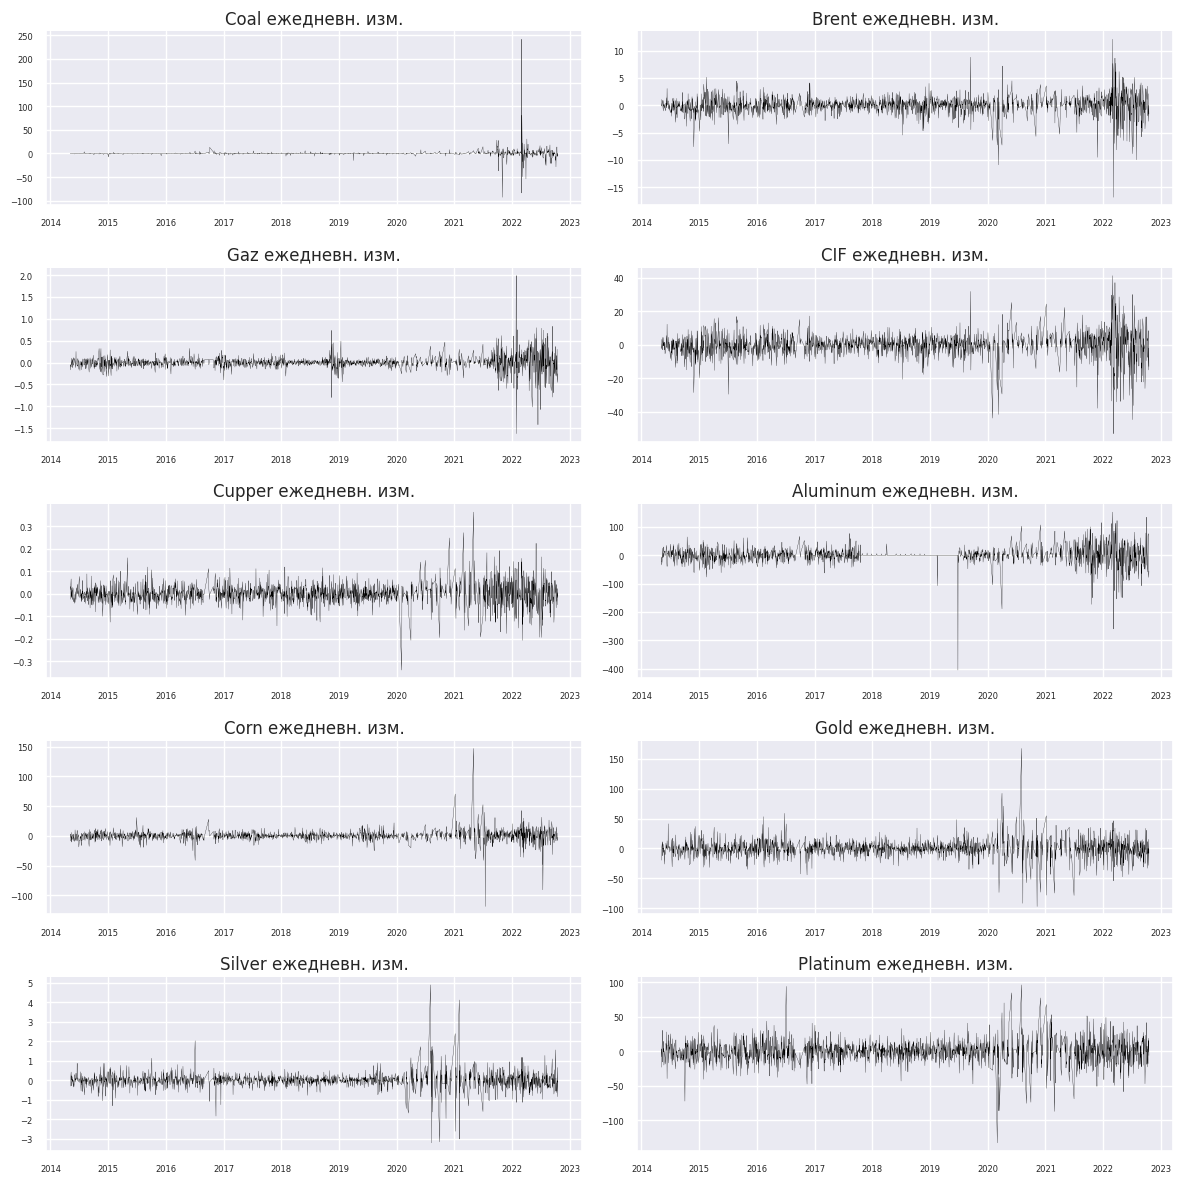

In [299]:
# графики ежедн изм
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=100, figsize=(12,12)) 
for i, ax in enumerate(axes.flatten()):
    data_temp = df_diff[df_diff.columns[i]]
    ax.plot(data_temp, color='black', linewidth=0.2)
    # Decorations
    ax.set_title(df_diff.columns[i] + ' ежедневн. изм.')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.grid(1)

plt.tight_layout();

In [300]:
# Логарифмическое изм.
# стр. 276 "Python для финансовых расчетов" для шкалиованных значений см ниже

# rets = np.log(df / df.shift(1))

# rets.dropna(inplace=True)

# rets

# отключил т.к. дублирует обычную волатильность

In [301]:
# графики логарифмического изм
# fig, axes = plt.subplots(nrows=5, ncols=2, dpi=100, figsize=(12,12)) 
# for i, ax in enumerate(axes.flatten()):
#     data_temp = rets[rets.columns[i]]
#     ax.plot(data_temp, color='black', linewidth=0.2)
#     # Decorations
#     ax.set_title(rets.columns[i] + ' логаримм. изм.')
#     ax.xaxis.set_ticks_position('none')
#     ax.yaxis.set_ticks_position('none')
#     ax.spines["top"].set_alpha(0)
#     ax.tick_params(labelsize=6)
#     ax.grid(1)

# plt.tight_layout();

# отключил т.к. дублирует обычную волатильность

In [302]:
# Регрессионный анализ по методу наименьших квадратов

# reg = np.polyfit(rets['Coal'], rets['Brent'], deg=1)

# ax = rets.plot(kind='scatter', x = 'Coal', y = 'Brent', figsize=(6, 4))
# ax.plot(rets['Coal'], np.polyval(reg, rets['Coal']), 'r', lw=2)

In [303]:
# Кореляция логарифм. изм. ежедневных значений в $'

# corr2 = rets.corr()

# corr2

In [304]:
# Корреляция логарифм изм график heatmap

# sns.set(rc = {'figure.figsize':(8, 6)})


# sns.heatmap(corr2, cmap='Blues', annot=True).set_title('Корреляция логарифм. изм. ежедневных значений в $')

# отключил т.к. дублирует обычную волатильность

In [305]:
# Корреляция скользящим окном Уголь - Нефть

# ax = rets['Coal'].rolling(window=180).corr(rets['Brent']).plot(figsize=(8, 4))
# ax.axhline(rets.corr().iloc[0, 1], c='r') # значение за весь период

# отключил

In [306]:
# проверка
# rets.corr().iloc[0, 1]

In [307]:
# наглядности в проверке
# rets.corr()

## 04. Шкалирование временных рядов. 
###### df1_scaler

В данном случае шкалирование произвожу методом MinMaxScaler в диапазоне (0, 1)


[Ссылка на оглавление](######Start)

In [437]:
# Шкалирование 

scalerMMS = preprocessing.MinMaxScaler()

# scalerSS = preprocessing.StandardScaler()

# scalerN = preprocessing.Normalizer() # так все в единицы переводит

# 
# scalerMMS.inverse_transform(dataScaled)

In [309]:
# Шкалирование получение Series
series_scaler = scalerMMS.fit_transform(df)
series_scaler

array([[0.0914776 , 0.80117843, 0.39948322, ..., 0.25731989, 0.41056172,
        0.93145581],
       [0.09072716, 0.8113476 , 0.39222436, ..., 0.23763359, 0.39251774,
        0.9043408 ],
       [0.0914776 , 0.81049228, 0.3715551 , ..., 0.23643448, 0.38024777,
        0.90818105],
       ...,
       [0.59013932, 0.65453331, 0.60297735, ..., 0.59048659, 0.31534939,
        0.28930522],
       [0.57763213, 0.65443832, 0.54712105, ..., 0.60577594, 0.35498613,
        0.31106714],
       [0.57050301, 0.63932709, 0.51587103, ..., 0.59778153, 0.34879097,
        0.3037356 ]])

In [310]:
# DataFrame ежедневных данных из series с нормализованными данными,

df_scaler = pd.DataFrame(series_scaler, index=df.index)

df_scaler.columns = col

df_scaler

Coal    Brent      Gaz      CIF   Cupper  Aluminum     Corn  \
Date                                                                         
2014-05-06  0.09148  0.80118  0.39948  0.68485  0.37983   0.29771  0.40929   
2014-05-07  0.09073  0.81135  0.39222  0.69028  0.37163   0.28790  0.40397   
2014-05-08  0.09148  0.81049  0.37156  0.68782  0.38234   0.28490  0.40977   
2014-05-09  0.09148  0.80907  0.36651  0.68400  0.38836   0.27065  0.39381   
2014-05-12  0.09135  0.81401  0.35458  0.68654  0.41044   0.26280  0.37929   
...             ...      ...      ...      ...      ...       ...      ...   
2022-10-12  0.60390  0.66233  0.60076  0.68527  0.50343   0.35533  0.75762   
2022-10-13  0.58764  0.68247  0.63841  0.69954  0.51112   0.38662  0.76681   
2022-10-14  0.59014  0.65453  0.60298  0.67397  0.50544   0.36586  0.75133   
2022-10-17  0.57763  0.65444  0.54712  0.67078  0.50711   0.33364  0.73924   
2022-10-18  0.57050  0.63933  0.51587  0.64883  0.49072   0.31082  0.73440   

               Gold   Silver  Platinum  
Date                                    
2014-05-06  0.25732  0.41056   0.93146  
2014-05-07  0.23763  0.39252   0.90434  
2014-05-08  0.23643  0.38025   0.90818  
2014-05-09  0.23633  0.37923   0.89864  
2014-05-12  0.24463  0.40467   0.91260  
...             ...      ...       ...  
2022-10-12  0.61907  0.36726   0.27313  
2022-10-13  0.61877  0.36605   0.29105  
2022-10-14  0.59049  0.31535   0.28931  
2022-10-17  0.60578  0.35499   0.31107  
2022-10-18  0.59778  0.34879   0.30374  

[1838 rows x 10 columns]

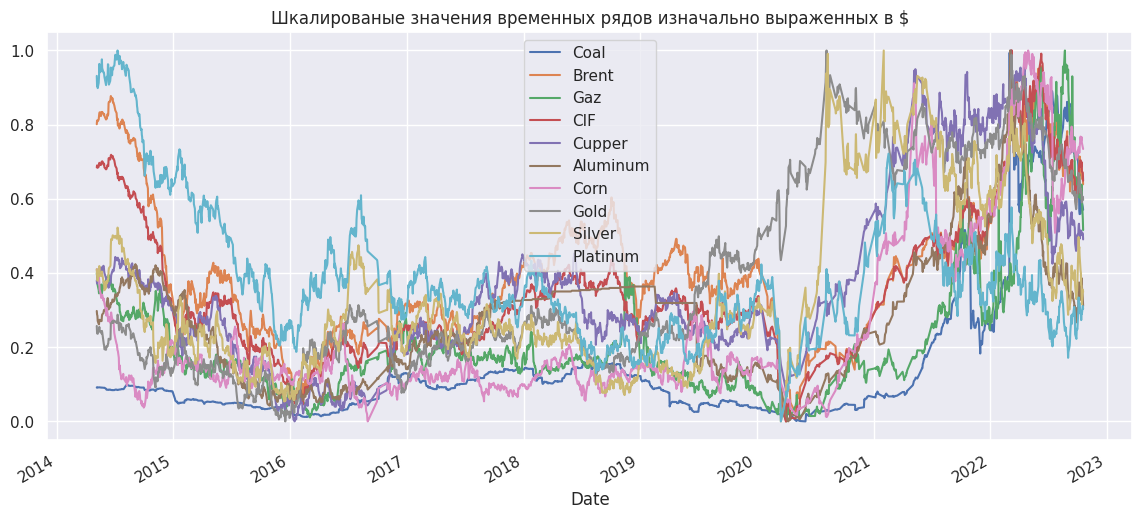

In [311]:
# График шкалированных врем рядов для наглядности
# В целом вид очень зашумленного и переполненного графика

df_scaler.plot(figsize=(14, 6), grid=True, title='Шкалированые значения временных рядов изначально выраженных в $');

In [312]:
# графики для наглядности. Шкалирование. Preprocessing.MinMaxScaler.  
# fig, axes = plt.subplots(nrows=5, ncols=2, dpi=100, figsize=(12,12)) 
# for i, ax in enumerate(axes.flatten()):
#     data_temp = df_scaler[df_scaler.columns[i]]
#     ax.plot(data_temp, color='green', linewidth=1)
#     # Decorations
#     ax.set_title(df_scaler.columns[i]+' scaler')
#     ax.xaxis.set_ticks_position('none')
#     ax.yaxis.set_ticks_position('none')
#     ax.spines["top"].set_alpha(0)
#     ax.tick_params(labelsize=6)
#     ax.grid(1)

# plt.tight_layout();


# пока отключил 

In [313]:
# Добавляю скользящие средние шкалированных значений

df_scaler_roll_mean = df_scaler.rolling(180, min_periods=30).mean()

df_scaler_roll_mean

Coal    Brent      Gaz      CIF   Cupper  Aluminum     Corn  \
Date                                                                         
2014-05-06      NaN      NaN      NaN      NaN      NaN       NaN      NaN   
2014-05-07      NaN      NaN      NaN      NaN      NaN       NaN      NaN   
2014-05-08      NaN      NaN      NaN      NaN      NaN       NaN      NaN   
2014-05-09      NaN      NaN      NaN      NaN      NaN       NaN      NaN   
2014-05-12      NaN      NaN      NaN      NaN      NaN       NaN      NaN   
...             ...      ...      ...      ...      ...       ...      ...   
2022-10-12  0.70073  0.76871  0.66102  0.77904  0.71027   0.55118  0.79143   
2022-10-13  0.70223  0.76895  0.66270  0.77940  0.70835   0.54960  0.79219   
2022-10-14  0.70374  0.76908  0.66283  0.77965  0.70656   0.54787  0.79289   
2022-10-17  0.70516  0.76916  0.66376  0.77984  0.70498   0.54588  0.79340   
2022-10-18  0.70654  0.76910  0.66436  0.77988  0.70329   0.54388  0.79399   

               Gold   Silver  Platinum  
Date                                    
2014-05-06      NaN      NaN       NaN  
2014-05-07      NaN      NaN       NaN  
2014-05-08      NaN      NaN       NaN  
2014-05-09      NaN      NaN       NaN  
2014-05-12      NaN      NaN       NaN  
...             ...      ...       ...  
2022-10-12  0.76684  0.53836   0.34003  
2022-10-13  0.76595  0.53671   0.33913  
2022-10-14  0.76511  0.53515   0.33838  
2022-10-17  0.76440  0.53394   0.33785  
2022-10-18  0.76359  0.53266   0.33720  

[1838 rows x 10 columns]

In [314]:
# df_scaler_roll_mean.plot(figsize=(14, 6), grid=True, title='Скользящие средние шкалированых значений')
# пока отключил т.к. сложно интерпретируемо


In [315]:
# Cumulative Moving Average (CMA)

# df_scaler_cma = df_scaler.expanding().mean()

df_scaler_cma = df_scaler.expanding(180).mean()

df_scaler_cma



Coal    Brent      Gaz      CIF   Cupper  Aluminum     Corn  \
Date                                                                         
2014-05-06      NaN      NaN      NaN      NaN      NaN       NaN      NaN   
2014-05-07      NaN      NaN      NaN      NaN      NaN       NaN      NaN   
2014-05-08      NaN      NaN      NaN      NaN      NaN       NaN      NaN   
2014-05-09      NaN      NaN      NaN      NaN      NaN       NaN      NaN   
2014-05-12      NaN      NaN      NaN      NaN      NaN       NaN      NaN   
...             ...      ...      ...      ...      ...       ...      ...   
2022-10-12  0.15712  0.41501  0.22342  0.35870  0.36106   0.28733  0.24455   
2022-10-13  0.15735  0.41516  0.22365  0.35888  0.36114   0.28738  0.24483   
2022-10-14  0.15759  0.41529  0.22386  0.35905  0.36122   0.28742  0.24511   
2022-10-17  0.15782  0.41542  0.22403  0.35922  0.36130   0.28745  0.24538   
2022-10-18  0.15804  0.41554  0.22419  0.35938  0.36137   0.28746  0.24564   

               Gold   Silver  Platinum  
Date                                    
2014-05-06      NaN      NaN       NaN  
2014-05-07      NaN      NaN       NaN  
2014-05-08      NaN      NaN       NaN  
2014-05-09      NaN      NaN       NaN  
2014-05-12      NaN      NaN       NaN  
...             ...      ...       ...  
2022-10-12  0.36401  0.32804   0.38464  
2022-10-13  0.36415  0.32806   0.38459  
2022-10-14  0.36427  0.32805   0.38454  
2022-10-17  0.36440  0.32806   0.38450  
2022-10-18  0.36453  0.32808   0.38446  

[1838 rows x 10 columns]

In [316]:
# df_scaler_cma.plot(figsize=(14, 6), grid=True, title='Коммулятивная скользящие средние шкалированых значений')
# пока отключил т.к. сложно интерпретируемо

In [317]:
# The Exponential Moving average (EMA)
# Добавляю экспоненциальная скользящая средняя шкалированных значений

# df_scaler_ema = df_scaler.ewm(alpha=0.1, adjust=False).mean()

# df_scaler_ema = df_scaler.ewm(alpha=0.1).mean()

# df_scaler_ema = df_scaler.ewm(span=90).mean()

df_scaler_ema = df_scaler.ewm(halflife = 30).mean()

df_scaler_ema



Coal    Brent      Gaz      CIF   Cupper  Aluminum     Corn  \
Date                                                                         
2014-05-06  0.09148  0.80118  0.39948  0.68485  0.37983   0.29771  0.40929   
2014-05-07  0.09110  0.80632  0.39581  0.68760  0.37568   0.29275  0.40660   
2014-05-08  0.09123  0.80774  0.38754  0.68767  0.37795   0.29007  0.40768   
2014-05-09  0.09129  0.80809  0.38210  0.68672  0.38065   0.28505  0.40409   
2014-05-12  0.09130  0.80933  0.37634  0.68668  0.38688   0.28039  0.39890   
...             ...      ...      ...      ...      ...       ...      ...   
2022-10-12  0.73218  0.71195  0.73921  0.71831  0.57332   0.39738  0.73680   
2022-10-13  0.72888  0.71128  0.73691  0.71788  0.57190   0.39714  0.73749   
2022-10-14  0.72571  0.70998  0.73385  0.71688  0.57039   0.39642  0.73781   
2022-10-17  0.72233  0.70871  0.72958  0.71583  0.56894   0.39499  0.73784   
2022-10-18  0.71886  0.70713  0.72470  0.71429  0.56715   0.39306  0.73776   

               Gold   Silver  Platinum  
Date                                    
2014-05-06  0.25732  0.41056   0.93146  
2014-05-07  0.24736  0.40144   0.91774  
2014-05-08  0.24364  0.39421   0.91448  
2014-05-09  0.24175  0.39033   0.91038  
2014-05-12  0.24235  0.39333   0.91085  
...             ...      ...       ...  
2022-10-12  0.68583  0.42876   0.28644  
2022-10-13  0.68430  0.42733   0.28655  
2022-10-14  0.68215  0.42477   0.28661  
2022-10-17  0.68041  0.42318   0.28717  
2022-10-18  0.67852  0.42148   0.28755  

[1838 rows x 10 columns]

In [318]:
# df_scaler_ema.plot(figsize=(14, 6), grid=True, title='Экспоненциальная скользящая средняя шкалированых значений')

# пока отключил т.к. сложно интерпретируемо

In [319]:
# df по шкалированным значениям стоимости угля
# полностью соотвествует первому графику в данном файле

df_scaler_coal = pd.concat([df_scaler['Coal'], df_scaler_roll_mean['Coal'], df_scaler_cma['Coal'], df_scaler_ema['Coal']], axis=1)

df_scaler_coal.columns = ['scaler', 'roll_mean', 'cma', 'ema']

df_scaler_coal

scaler  roll_mean      cma      ema
Date                                            
2014-05-06  0.09148        NaN      NaN  0.09148
2014-05-07  0.09073        NaN      NaN  0.09110
2014-05-08  0.09148        NaN      NaN  0.09123
2014-05-09  0.09148        NaN      NaN  0.09129
2014-05-12  0.09135        NaN      NaN  0.09130
...             ...        ...      ...      ...
2022-10-12  0.60390    0.70073  0.15712  0.73218
2022-10-13  0.58764    0.70223  0.15735  0.72888
2022-10-14  0.59014    0.70374  0.15759  0.72571
2022-10-17  0.57763    0.70516  0.15782  0.72233
2022-10-18  0.57050    0.70654  0.15804  0.71886

[1838 rows x 4 columns]

<AxesSubplot: title={'center': 'График по шкалированным значениям стоимости угля'}, xlabel='Date'>

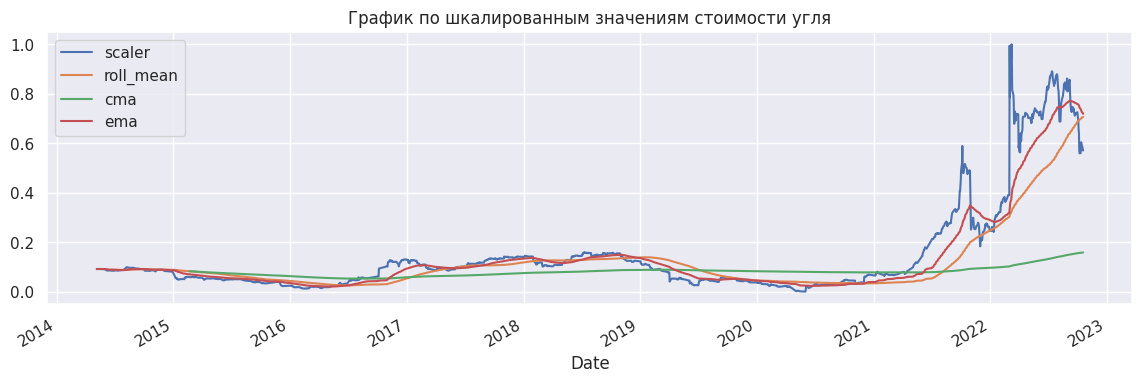

In [320]:
df_scaler_coal.plot(figsize=(14, 4), grid=True, title='График по шкалированным значениям стоимости угля')

## 05. Перход к измерению в унциях золота
###### df_gold

[Ссылка на оглавление](######Start)

In [321]:
# Прересчет в унции золота

df_gold = pd.DataFrame()

for column in df.columns:
    df_gold[column] = df['Gold'] / df[column]
    

df_gold

Coal     Brent        Gaz      CIF     Cupper  Aluminum  \
Date                                                                      
2014-05-06  17.40918  12.22025  272.61932  2.01587  425.46342   0.60214   
2014-05-07  17.21576  11.91714  271.85655  1.97577  422.42256   0.59963   
2014-05-08  17.13107  11.91596  281.58356  1.97833  417.64802   0.60110   
2014-05-09  17.12974  11.93160  284.10947  1.98504  415.19110   0.61089   
2014-05-12  17.25166  11.95093  292.19666  1.99323  409.15836   0.62042   
...              ...       ...        ...      ...        ...       ...   
2022-10-12   5.96536  18.06706  259.56489  2.57266  484.91800   0.72237   
2022-10-13   6.10603  17.65888  247.73772  2.53934  481.61500   0.69933   
2022-10-14   5.98069  17.91662  254.40879  2.55478  475.78610   0.70226   
2022-10-17   6.14842  18.08557  276.21270  2.58615  479.52541   0.73327   
2022-10-18   6.18414  18.31612  287.03221  2.62663  484.07455   0.74802   

               Corn  Gold    Silver  Platinum  
Date                                           
2014-05-06  2.55029   1.0  66.75682   0.89788  
2014-05-07  2.52543   1.0  66.77376   0.89873  
2014-05-08  2.50833   1.0  67.42432   0.89583  
2014-05-09  2.54911   1.0  67.47917   0.90090  
2014-05-12  2.60422   1.0  66.44102   0.89916  
...             ...   ...       ...       ...  
2022-10-12  2.41025   1.0  88.47865   1.87379  
2022-10-13  2.39341   1.0  88.55658   1.84164  
2022-10-14  2.38014   1.0  91.12961   1.81343  
2022-10-17  2.42429   1.0  88.73300   1.79329  
2022-10-18  2.42144   1.0  88.79436   1.79688  

[1838 rows x 10 columns]

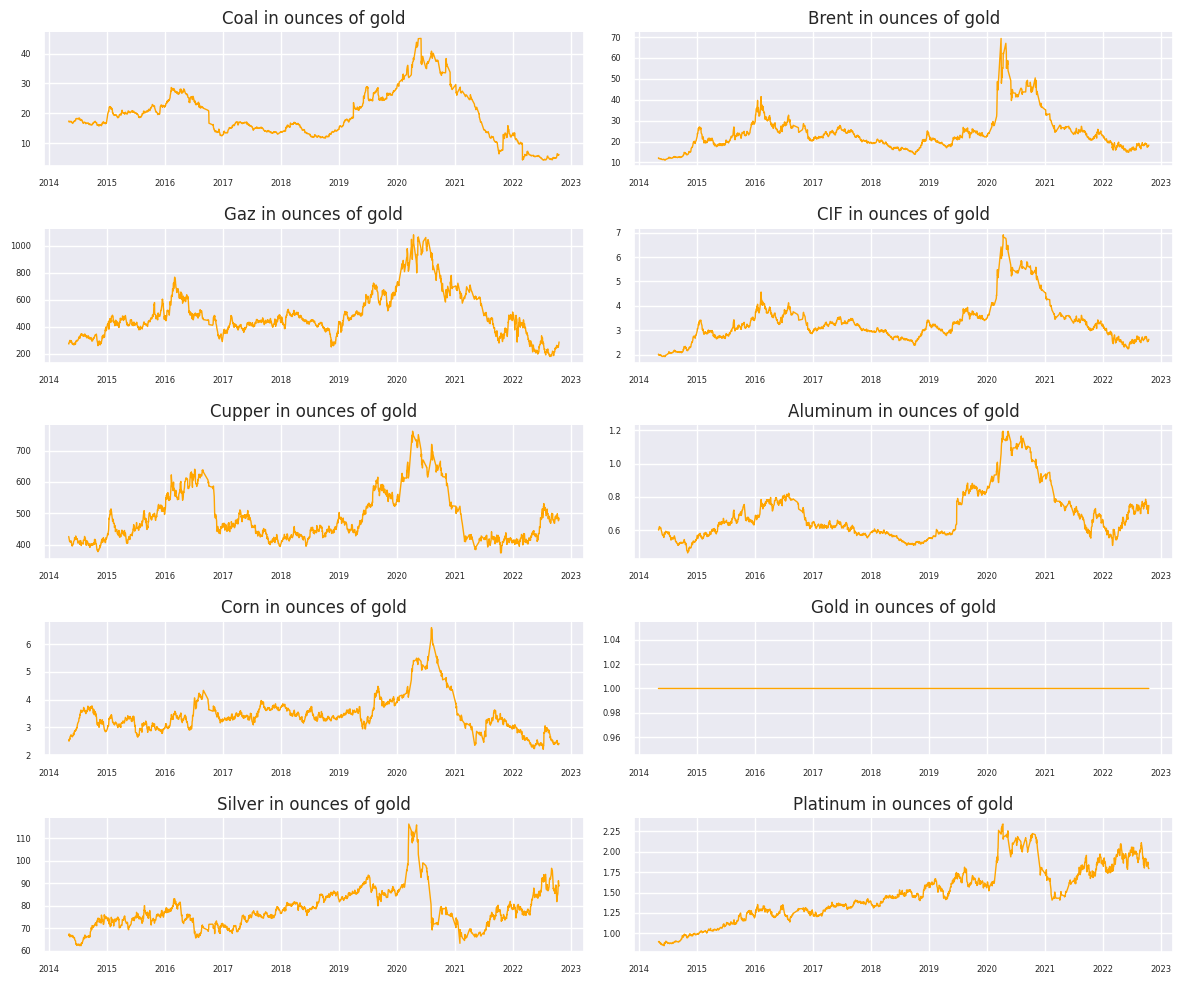

In [322]:
# графики стоимости выраженыех в унциях золота
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=100, figsize=(12,10)) 
for i, ax in enumerate(axes.flatten()):
    data_temp = df_gold[df_gold.columns[i]]
    ax.plot(data_temp, color='orange', linewidth=1)
    # Decorations
    ax.set_title(df_gold.columns[i]+' in ounces of gold')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.grid(1)

plt.tight_layout();

### 05.1 Корреляция временных рядов выраженная в унциях золота
###### corr_gold

[Ссылка на оглавление](######Start)

In [323]:
# Корреляция в показателях пересчитаных в унции золота.

corr_gold = df_gold.corr()
corr_gold

Coal    Brent      Gaz      CIF   Cupper  Aluminum     Corn  \
Coal      1.00000  0.72260  0.87046  0.76300  0.74063   0.70607  0.68783   
Brent     0.72260  1.00000  0.77532  0.97755  0.76807   0.81330  0.64264   
Gaz       0.87046  0.77532  1.00000  0.84668  0.70771   0.75353  0.70240   
CIF       0.76300  0.97755  0.84668  1.00000  0.79168   0.84732  0.73074   
Cupper    0.74063  0.76807  0.70771  0.79168  1.00000   0.83149  0.60542   
Aluminum  0.70607  0.81330  0.75353  0.84732  0.83149   1.00000  0.58764   
Corn      0.68783  0.64264  0.70240  0.73074  0.60542   0.58764  1.00000   
Gold          NaN      NaN      NaN      NaN      NaN       NaN      NaN   
Silver    0.16326  0.27612  0.33872  0.33499  0.40595   0.34756  0.22150   
Platinum  0.00533  0.40365  0.29579  0.46130  0.31181   0.51770  0.20237   

          Gold   Silver  Platinum  
Coal       NaN  0.16326   0.00533  
Brent      NaN  0.27612   0.40365  
Gaz        NaN  0.33872   0.29579  
CIF        NaN  0.33499   0.46130  
Cupper     NaN  0.40595   0.31181  
Aluminum   NaN  0.34756   0.51770  
Corn       NaN  0.22150   0.20237  
Gold       NaN      NaN       NaN  
Silver     NaN  1.00000   0.65611  
Platinum   NaN  0.65611   1.00000

Text(0.5, 1.0, 'Корреляции показателей, выраженных в унциях золота')

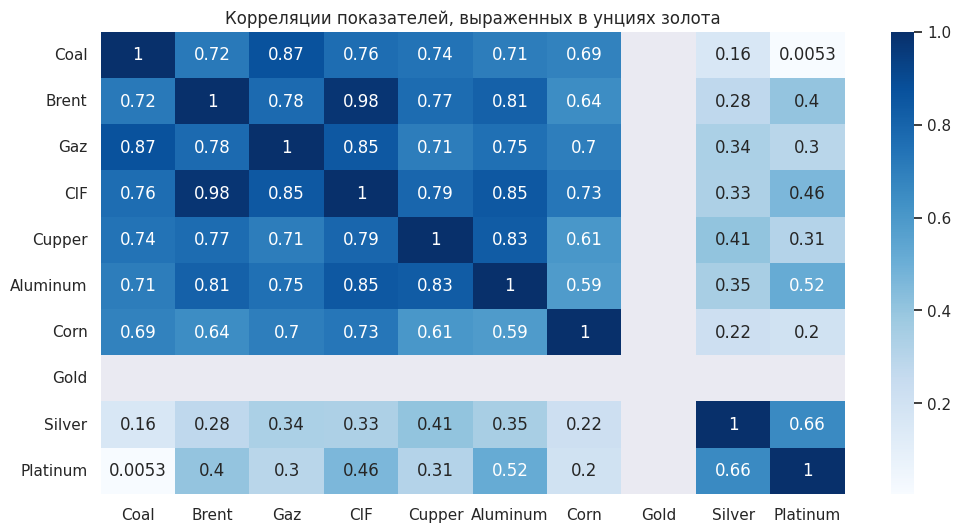

In [324]:
# граф корреляции средн мес знач выраж в унциях золота

sns.set(rc = {'figure.figsize':(12,6)})
sns.heatmap(corr_gold, cmap='Blues', annot=True).set_title('Корреляции показателей, выраженных в унциях золота')

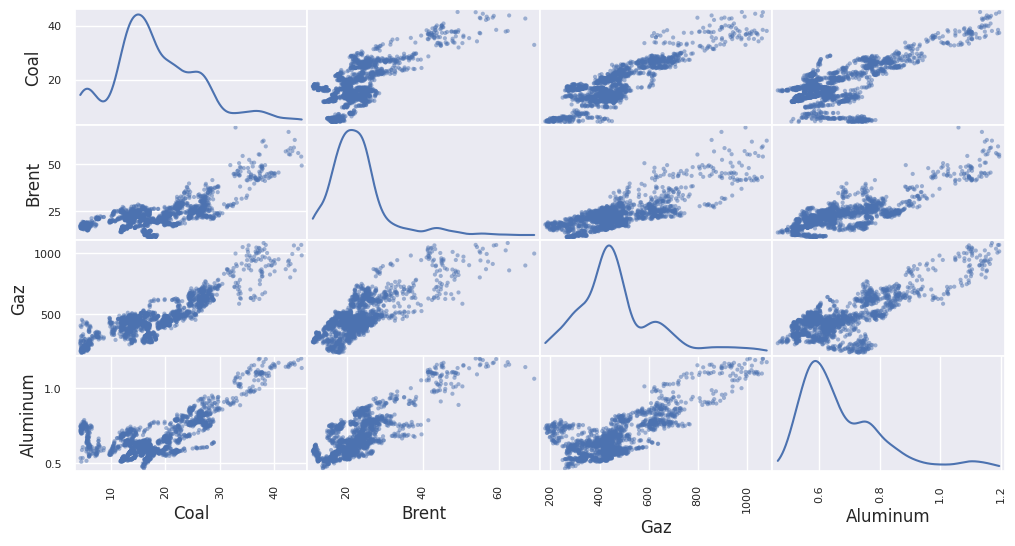

In [325]:
# Корреляция график scatter_matrix по отдельным временным рядам, выраженных в унциях золота

df1_gold = df_gold[["Coal", 'Brent', "Gaz", 'Aluminum']]

print(df1_gold.corr())
pd.plotting.scatter_matrix(df1_gold, diagonal='kde'); # , diagonal='kde'

In [326]:
# Нормализовываю знач в унциях золота

# series:
series_scaler_gold = scalerMMS.fit_transform(df_gold)

series_scaler_gold

# DataFrame с нормализованными данными:
df_gold_scaler = pd.DataFrame(series_scaler_gold, index=df_gold.index)

df_gold_scaler.columns = col

df_gold_scaler

Coal    Brent      Gaz      CIF   Cupper  Aluminum     Corn  \
Date                                                                         
2014-05-06  0.32094  0.01863  0.10368  0.01965  0.13460   0.19091  0.07674   
2014-05-07  0.31619  0.01342  0.10283  0.01162  0.12679   0.18748  0.07106   
2014-05-08  0.31411  0.01340  0.11362  0.01213  0.11452   0.18949  0.06716   
2014-05-09  0.31407  0.01367  0.11642  0.01348  0.10821   0.20286  0.07647   
2014-05-12  0.31707  0.01400  0.12539  0.01511  0.09271   0.21587  0.08907   
...             ...      ...      ...      ...      ...       ...      ...   
2022-10-12  0.03974  0.11908  0.08920  0.13108  0.28734   0.35503  0.04475   
2022-10-13  0.04319  0.11207  0.07608  0.12441  0.27885   0.32358  0.04090   
2022-10-14  0.04011  0.11650  0.08348  0.12750  0.26388   0.32757  0.03787   
2022-10-17  0.04424  0.11940  0.10766  0.13378  0.27349   0.36990  0.04795   
2022-10-18  0.04511  0.12336  0.11966  0.14188  0.28517   0.39004  0.04730   

            Gold   Silver  Platinum  
Date                                 
2014-05-06   0.0  0.08374   0.03292  
2014-05-07   0.0  0.08405   0.03349  
2014-05-08   0.0  0.09607   0.03155  
2014-05-09   0.0  0.09709   0.03495  
2014-05-12   0.0  0.07790   0.03378  
...          ...      ...       ...  
2022-10-12   0.0  0.48514   0.68759  
2022-10-13   0.0  0.48658   0.66602  
2022-10-14   0.0  0.53413   0.64710  
2022-10-17   0.0  0.48984   0.63359  
2022-10-18   0.0  0.49097   0.63600  

[1838 rows x 10 columns]

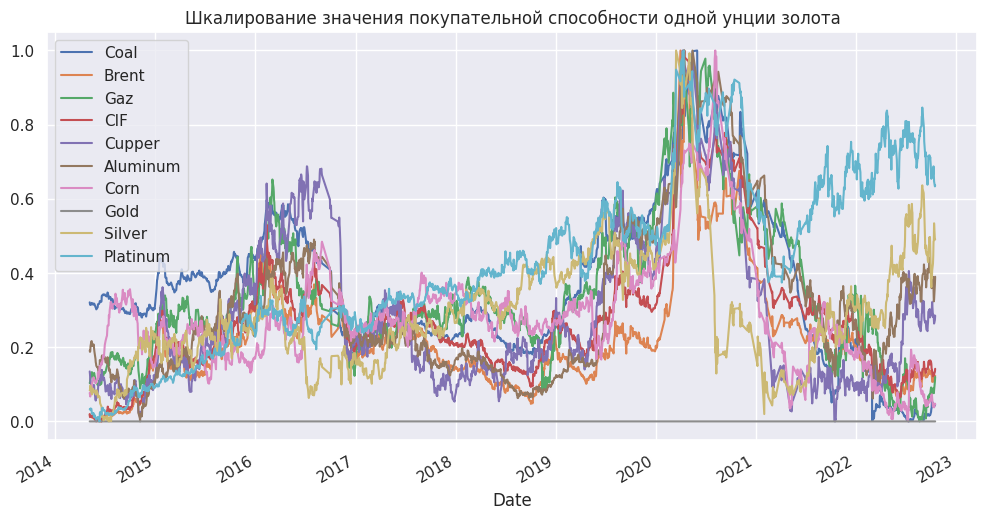

In [327]:
# График шкалированных значения временных рядов изначально выраженных в унциях золота
df_gold_scaler.plot(figsize=(12, 6), grid=True, title='Шкалирование значения покупательной способности одной унции золота');

На вышепредставленном графике характерно виднен согласованный рост до максимальных значений в первой половине 2020 года - начало COVID-19

## 06. Перход к измерению в баррелях нефти
###### df_brent

[Ссылка на оглавление](######Start)

In [328]:
# Прересчет в баррели нефти

df_brent = pd.DataFrame()

for column in df.columns:
    df_brent[column] = df['Brent'] / df[column]
    

df_brent

Coal  Brent       Gaz      CIF    Cupper  Aluminum     Corn  \
Date                                                                         
2014-05-06  1.42462    1.0  22.30881  0.16496  34.81626   0.04927  0.20869   
2014-05-07  1.44462    1.0  22.81224  0.16579  35.44665   0.05032  0.21192   
2014-05-08  1.43766    1.0  23.63080  0.16602  35.04947   0.05044  0.21050   
2014-05-09  1.43566    1.0  23.81152  0.16637  34.79761   0.05120  0.21364   
2014-05-12  1.44354    1.0  24.44971  0.16678  34.23654   0.05191  0.21791   
...             ...    ...       ...      ...       ...       ...      ...   
2022-10-12  0.33018    1.0  14.36674  0.14240  26.83989   0.03998  0.13341   
2022-10-13  0.34578    1.0  14.02908  0.14380  27.27325   0.03960  0.13554   
2022-10-14  0.33381    1.0  14.19960  0.14259  26.55557   0.03920  0.13285   
2022-10-17  0.33996    1.0  15.27255  0.14300  26.51425   0.04054  0.13405   
2022-10-18  0.33763    1.0  15.67102  0.14341  26.42888   0.04084  0.13220   

               Gold   Silver  Platinum  
Date                                    
2014-05-06  0.08183  5.46280   0.07347  
2014-05-07  0.08391  5.60317   0.07541  
2014-05-08  0.08392  5.65832   0.07518  
2014-05-09  0.08381  5.65550   0.07551  
2014-05-12  0.08368  5.55949   0.07524  
...             ...      ...       ...  
2022-10-12  0.05535  4.89723   0.10371  
2022-10-13  0.05663  5.01485   0.10429  
2022-10-14  0.05581  5.08632   0.10122  
2022-10-17  0.05529  4.90629   0.09916  
2022-10-18  0.05460  4.84788   0.09810  

[1838 rows x 10 columns]

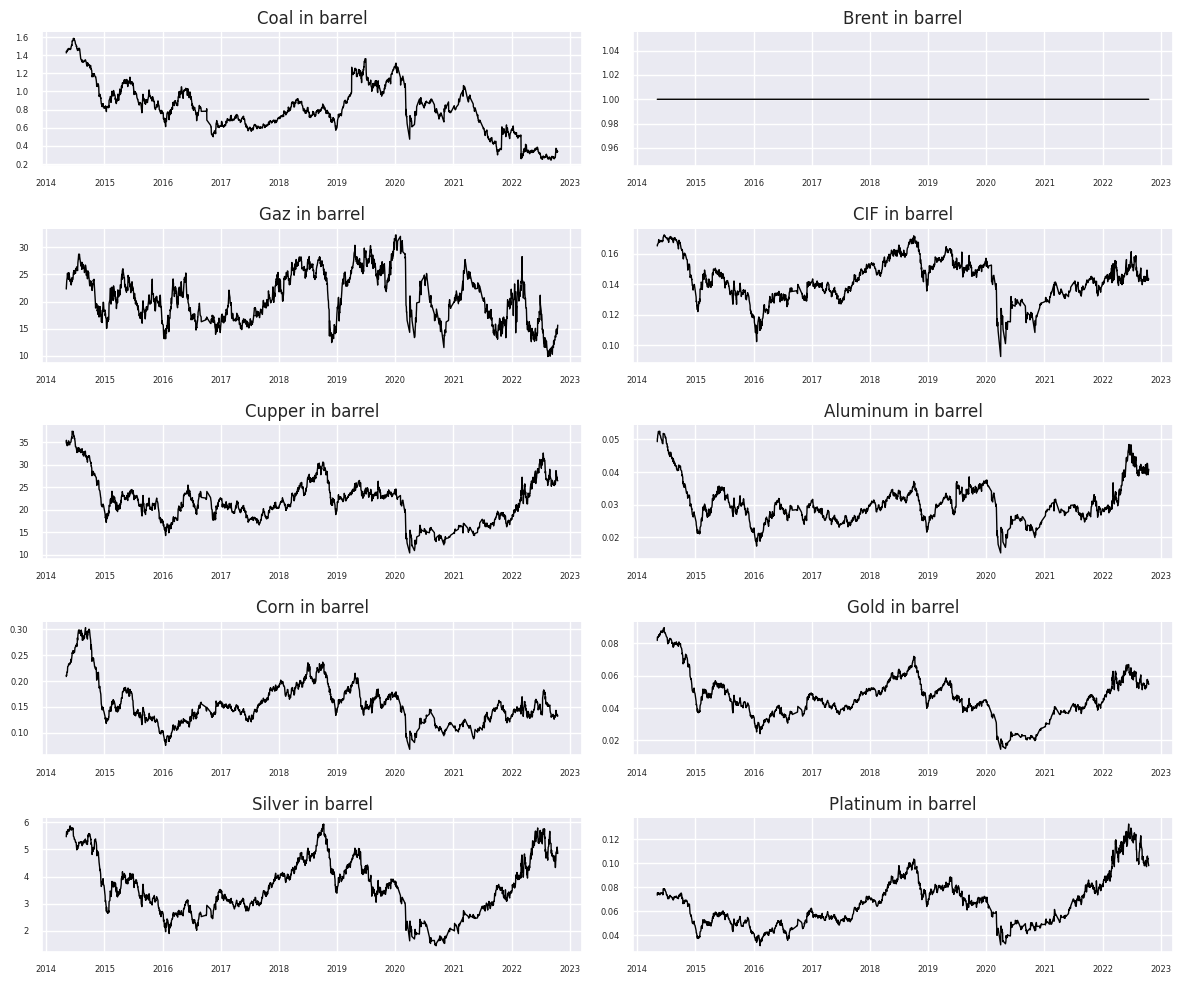

In [329]:
# графики стоимости выраженыех в баррелях нефти
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=100, figsize=(12,10)) 
for i, ax in enumerate(axes.flatten()):
    data_temp = df_brent[df_brent.columns[i]]
    ax.plot(data_temp, color='black', linewidth=1)
    # Decorations
    ax.set_title(df_brent.columns[i] + ' in barrel')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.grid(1)

plt.tight_layout();

### 06.1 Корреляция временных рядов выраженная в баррелях нефти
###### corr_brent

[Ссылка на оглавление](######Start)

In [330]:
# Корреляция в показателях пересчитаных в баррели нефти.

corr_brent = df_brent.corr()
corr_brent

Coal  Brent      Gaz      CIF   Cupper  Aluminum     Corn  \
Coal      1.00000    NaN  0.70566  0.36032  0.36340   0.29059  0.47060   
Brent         NaN    NaN      NaN      NaN      NaN       NaN      NaN   
Gaz       0.70566    NaN  1.00000  0.56726  0.34650   0.28972  0.49693   
CIF       0.36032    NaN  0.56726  1.00000  0.83999   0.73981  0.88611   
Cupper    0.36340    NaN  0.34650  0.83999  1.00000   0.87562  0.79731   
Aluminum  0.29059    NaN  0.28972  0.73981  0.87562   1.00000  0.64984   
Corn      0.47060    NaN  0.49693  0.88611  0.79731   0.64984  1.00000   
Gold      0.26596    NaN  0.29628  0.87293  0.90252   0.80595  0.85762   
Silver    0.14499    NaN  0.30012  0.88927  0.89170   0.78945  0.77546   
Platinum -0.32216    NaN  0.06106  0.65380  0.58833   0.63129  0.39792   

             Gold   Silver  Platinum  
Coal      0.26596  0.14499  -0.32216  
Brent         NaN      NaN       NaN  
Gaz       0.29628  0.30012   0.06106  
CIF       0.87293  0.88927   0.65380  
Cupper    0.90252  0.89170   0.58833  
Aluminum  0.80595  0.78945   0.63129  
Corn      0.85762  0.77546   0.39792  
Gold      1.00000  0.93011   0.62298  
Silver    0.93011  1.00000   0.79303  
Platinum  0.62298  0.79303   1.00000

Text(0.5, 1.0, 'Корреляции показателей, выраженных в баррелях нефти')

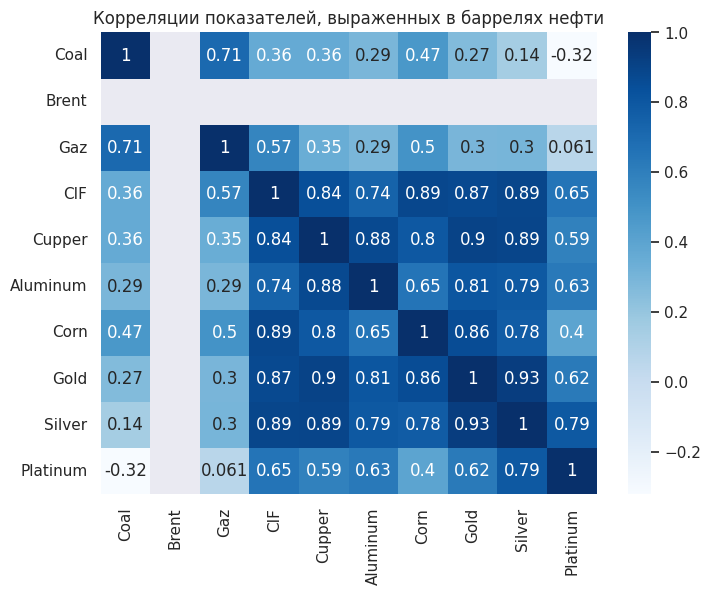

In [331]:
# граф корреляции средн мес знач выраж в баррелях нефти.

sns.set(rc = {'figure.figsize':(8,6)})
sns.heatmap(corr_brent, cmap='Blues', annot=True).set_title('Корреляции показателей, выраженных в баррелях нефти')

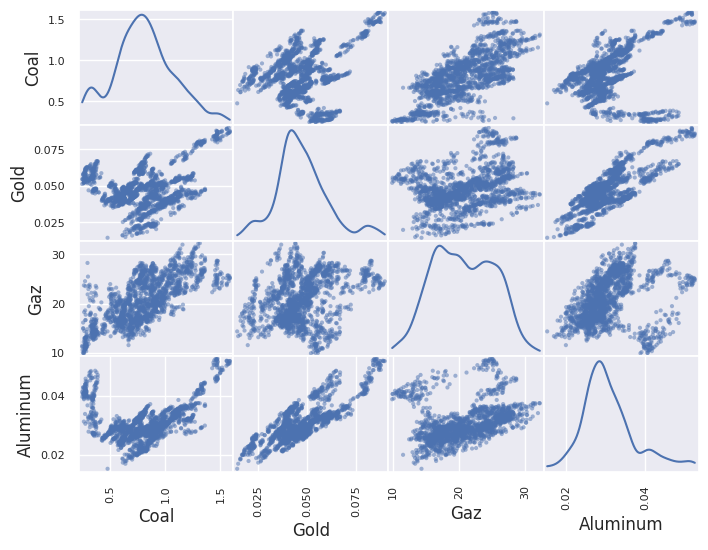

In [332]:
# Корреляция график scatter_matrix по отдельным временным рядам, выраженных в баррелях неефти.

df1_brent = df_brent[["Coal", 'Gold', "Gaz", 'Aluminum']]

print(df1_brent.corr())
pd.plotting.scatter_matrix(df1_brent, diagonal='kde'); # , diagonal='kde'

In [333]:
# Нормализовываю знач в баррелях неефти.

# series:
series_scaler_brent = scalerMMS.fit_transform(df_brent)

series_scaler_brent

# DataFrame с нормализованными данными:
df_brent_scaler = pd.DataFrame(series_scaler_brent, index=df_brent.index)

df_brent_scaler.columns = col

df_brent_scaler

Coal  Brent      Gaz      CIF   Cupper  Aluminum     Corn  \
Date                                                                       
2014-05-06  0.88053    0.0  0.55459  0.90859  0.90233   0.91394  0.59797   
2014-05-07  0.89545    0.0  0.57708  0.91902  0.92561   0.94197  0.61166   
2014-05-08  0.89025    0.0  0.61366  0.92192  0.91094   0.94542  0.60565   
2014-05-09  0.88877    0.0  0.62174  0.92625  0.90164   0.96572  0.61901   
2014-05-12  0.89464    0.0  0.65026  0.93147  0.88092   0.98494  0.63714   
...             ...    ...      ...      ...      ...       ...      ...   
2022-10-12  0.06452    0.0  0.19968  0.62541  0.60775   0.66408  0.27800   
2022-10-13  0.07615    0.0  0.18460  0.64304  0.62376   0.65385  0.28706   
2022-10-14  0.06722    0.0  0.19222  0.62789  0.59725   0.64292  0.27562   
2022-10-17  0.07181    0.0  0.24016  0.63294  0.59573   0.67919  0.28072   
2022-10-18  0.07008    0.0  0.25797  0.63809  0.59258   0.68712  0.27289   

               Gold   Silver  Platinum  
Date                                    
2014-05-06  0.89430  0.89520   0.41534  
2014-05-07  0.92191  0.92655   0.43442  
2014-05-08  0.92202  0.93887   0.43210  
2014-05-09  0.92056  0.93824   0.43531  
2014-05-12  0.91876  0.91679   0.43268  
...             ...      ...       ...  
2022-10-12  0.54297  0.76888   0.71267  
2022-10-13  0.55995  0.79515   0.71834  
2022-10-14  0.54914  0.81111   0.68811  
2022-10-17  0.54222  0.77090   0.66786  
2022-10-18  0.53299  0.75786   0.65752  

[1838 rows x 10 columns]

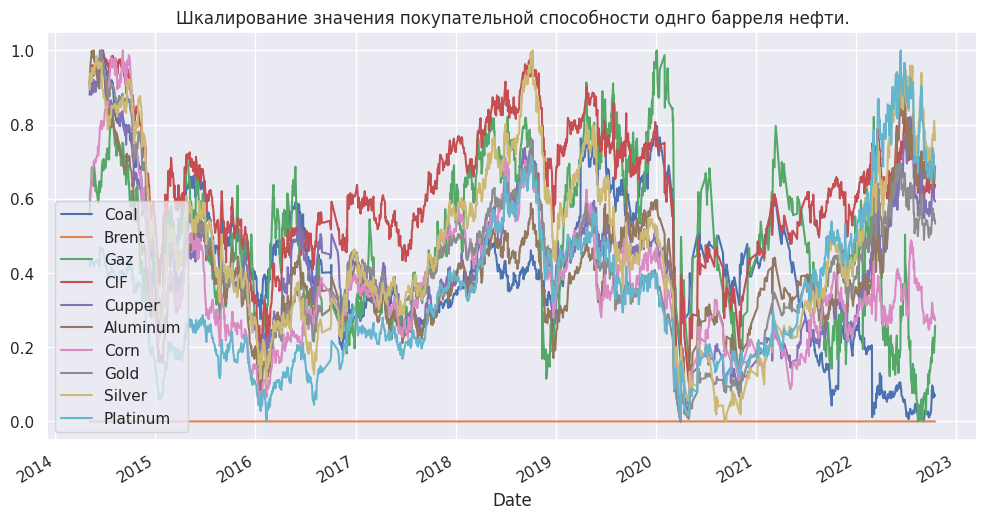

In [334]:
# График шкалированных значения временных рядов изначально выраженных в баррелях нефти.
df_brent_scaler.plot(figsize=(12, 6), grid=True, title='Шкалирование значения покупательной способности однго барреля нефти.');

В расчете на беррель нефти график выглядит противоположно в сравнении с графиком в унции золота. Покупательная способность барреля нефти падает с началом COVID-19.

## 07. Представление шкалированной стоимости угля в разных ед.измерения
###### df2

[Ссылка на оглавление](######Start)

Ниже представленный график шкалированнаной стоимость угля в разных ед.измерения необходимо интерпретировать.

На обсуждение: м.б. стоит это использовать для последующего прогнозирования.

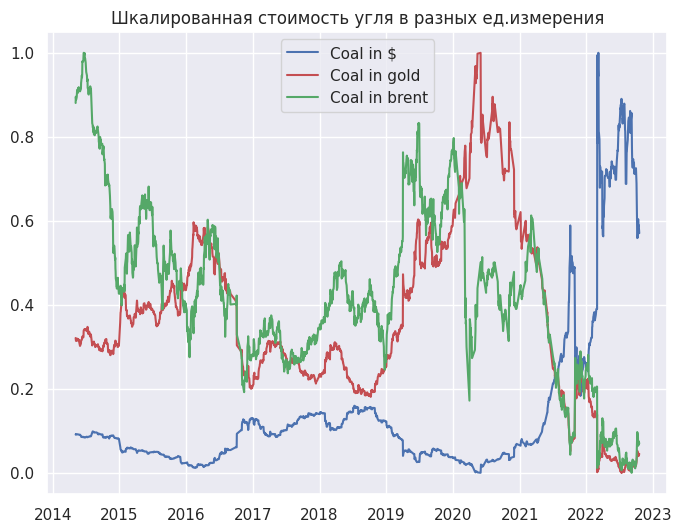

In [335]:
# График Шкалированнаной стоимость угля в разных ед.измерения

plt.plot(df_scaler['Coal'], label='Coal in $', color='b')
plt.plot(df_gold_scaler['Coal'], label='Coal in gold', color='r')
plt.plot(df_brent_scaler['Coal'], label='Coal in brent', color='g')
plt.Figure(figsize=(10,4))
plt.title('Шкалированная стоимость угля в разных ед.измерения')
plt.legend()
plt.show()

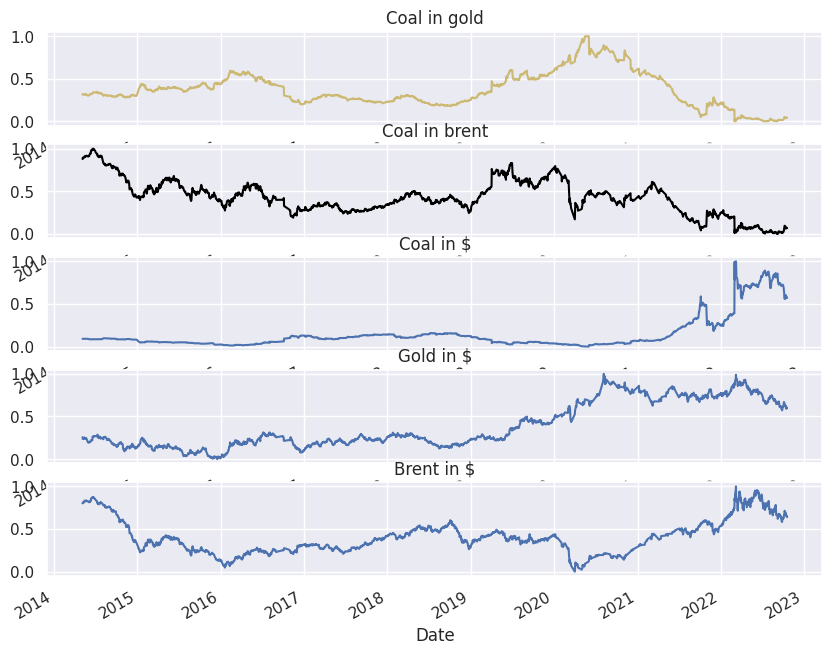

In [336]:
# Шкалированные графики
plt.figure(figsize=(10, 8))

plt.subplot(511)
df_gold_scaler['Coal'].plot(title='Coal in gold', c = 'y')

plt.subplot(512)
df_brent_scaler['Coal'].plot(title='Coal in brent', c = 'black')

plt.subplot(513)
df_scaler['Coal'].plot(title='Coal in $')

plt.subplot(514)
df_scaler['Gold'].plot(title='Gold in $')

plt.subplot(515)
df_scaler['Brent'].plot(title='Brent in $')


plt.show()

In [337]:
# dataframe со шкалированной стоимостью угля при разных ед изм.
df2 = pd.concat([df_scaler['Coal'], df_gold_scaler['Coal'], df_brent_scaler['Coal']], axis=1)

df2.columns = ['in_doll', 'in_gold', 'in_brent']

df2

in_doll  in_gold  in_brent
Date                                  
2014-05-06  0.09148  0.32094   0.88053
2014-05-07  0.09073  0.31619   0.89545
2014-05-08  0.09148  0.31411   0.89025
2014-05-09  0.09148  0.31407   0.88877
2014-05-12  0.09135  0.31707   0.89464
...             ...      ...       ...
2022-10-12  0.60390  0.03974   0.06452
2022-10-13  0.58764  0.04319   0.07615
2022-10-14  0.59014  0.04011   0.06722
2022-10-17  0.57763  0.04424   0.07181
2022-10-18  0.57050  0.04511   0.07008

[1838 rows x 3 columns]

### 07.1 Корреляция стоимости угля выраженная в разных единицах измеренния
###### corr2

[Ссылка на оглавление](######Start)

In [338]:
# Корреляция стоимости угля выраженная в разных единицах измеренния

corr2 = df2.corr()
corr2

in_doll  in_gold  in_brent
in_doll   1.00000 -0.71741  -0.69523
in_gold  -0.71741  1.00000   0.56562
in_brent -0.69523  0.56562   1.00000

Text(0.5, 1.0, 'Корреляция стоимости угля выраженная в разных единицах измеренния')

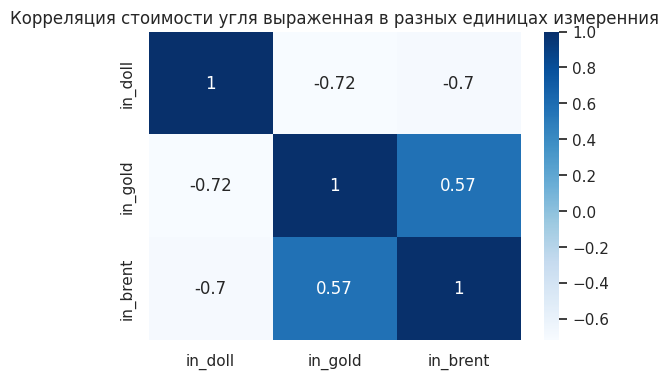

In [339]:
sns.set(rc = {'figure.figsize':(6,4)})
sns.heatmap(corr2, cmap='Blues', annot=True).set_title('Корреляция стоимости угля выраженная в разных единицах измеренния')

In [340]:
# Вычисление логарифмического изменения шкалированных значений при разных ед.измерения стоимости угля
#  тожедумаю что надо убрать это 

rets2 = np.log(df2 / df2.shift(1))

rets2.dropna(inplace=True)

rets2

in_doll  in_gold  in_brent
Date                                  
2014-05-07 -0.00824 -0.01492   0.01680
2014-05-08  0.00824 -0.00660  -0.00582
2014-05-09  0.00000 -0.00010  -0.00167
2014-05-12 -0.00137  0.00949   0.00659
2014-05-13  0.00000 -0.00103   0.00917
...             ...      ...       ...
2022-10-12  0.05908 -0.19184  -0.24566
2022-10-13 -0.02729  0.08341   0.16574
2022-10-14  0.00425 -0.07397  -0.12466
2022-10-17 -0.02142  0.09780   0.06605
2022-10-18 -0.01242  0.01964  -0.02448

[1837 rows x 3 columns]

Text(0.5, 1.0, 'Корреляция логарифм. изм. стоимости угля в разн. ед.измерения')

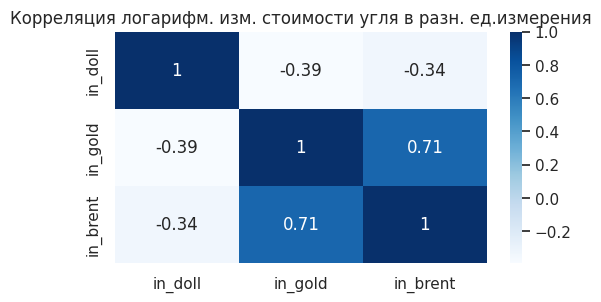

In [341]:
# Корреляция логарифм. изм. стоимости угля в разн. ед.измерения

print(rets2.corr())

sns.set(rc = {'figure.figsize':(6,3)})
sns.heatmap(rets2.corr(), cmap='Blues', annot=True).set_title('Корреляция логарифм. изм. стоимости угля в разн. ед.измерения')

In [342]:
# Корреляция логарифм. изм. стоимости угля в разн. ед.измерения, вычисляемую в пределах временного окна
# пока не понимаю как интерпретировать данный график

# ax = rets2['in_doll'].rolling(window=90).corr(rets2['in_gold']).plot(figsize=(8, 4), title='Корр логарифм. изм. стоимости угля в долл и золоте')
# ax.axhline(rets2.corr().iloc[0, 1], c='r') # значение корр за весь период

# сложно интерпретируемый график

In [343]:
# ax = rets2['in_doll'].rolling(window=90).corr(rets2['in_brent']).plot(figsize=(8, 4), title='Корр логарифм. изм. стоимости угля в долл и нефти')
# ax.axhline(rets2.corr().iloc[0, 2], c='r') # значение корр за весь период

# сложно интерпретируемый график

In [344]:
# ax = rets2['in_gold'].rolling(window=90).corr(rets2['in_brent']).plot(figsize=(8, 4), title='Корр логарифм. изм. стоимости угля в золоте и нефти')
# ax.axhline(rets2.corr().iloc[1, 2], c='r') # значение корр за весь период

# сложно интерпретируемый график

In [345]:
# Для наглядности логаримм. изм. шкалиров.знач. стоимости угля в разн. ед.измер.
# rets2.plot(figsize=(8, 4), grid=True, title='логаримм. изм. шкалиров.знач. стоимости угля в разн. ед.измер.');

# пока отключил

In [346]:
# графики логарифмического изм шкалир знач
# fig, axes = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(8,6)) 
# for i, ax in enumerate(axes.flatten()):
#     data_temp = rets2[rets2.columns[i]]
#     ax.plot(data_temp, color='black', linewidth=0.2)
#     # Decorations
#     ax.set_title(rets2.columns[i] + ' логарим. изм. шкалиров.знач.')
#     ax.xaxis.set_ticks_position('none')
#     ax.yaxis.set_ticks_position('none')
#     ax.spines["top"].set_alpha(0)
#     ax.tick_params(labelsize=6)
#     ax.grid(1)

# plt.tight_layout();

# пока отключил

## 08. Прогноз стоимости угля на основе ARIMA
###### df3

На примере временого ряда стоимости угля в разн ед изм.



[Ссылка на оглавление](######Start)

In [347]:
# Для напоминания: Стоимость угля в $
df['Coal']

Date
2014-05-06     75.15000
2014-05-07     74.85000
2014-05-08     75.15000
2014-05-09     75.15000
2014-05-12     75.10000
                ...    
2022-10-12    280.00000
2022-10-13    273.50000
2022-10-14    274.50000
2022-10-17    269.50000
2022-10-18    266.64999
Name: Coal, Length: 1838, dtype: float64

In [403]:
# делаю прореживание данных на среднемесячные значения
# Считаю, что нужно работать не с дневными значениями, т.к. корреляция с предыдущим днем почти равна ед.

df_month = df.resample('M').mean()

# и сразу делаю для дня
df_day = df.resample('D').mean()

df_month

Coal      Brent      Gaz        CIF   Cupper    Aluminum  \
Date                                                                        
2014-05-31   75.03611  109.41889  4.50928  653.30944  3.14394  2132.18056   
2014-06-30   72.62333  112.26222  4.58456  659.40000  3.09353  2222.88889   
2014-07-31   72.98722  107.75722  4.00583  635.34612  3.22617  2322.70833   
2014-08-31   77.15263  103.13053  3.90816  608.75631  3.15092  2386.17105   
2014-09-30   75.33150   98.14950  3.92230  588.15700  3.08983  2379.60000   
...               ...        ...      ...        ...      ...         ...   
2022-06-30  337.69714  117.66381  7.59790  778.41048  4.12540  2564.14286   
2022-07-31  383.89250  104.70500  7.18695  681.20600  3.39610  2400.58750   
2022-08-31  355.21087   97.74087  8.77948  669.55043  3.61500  2410.64130   
2022-09-30  338.91905   90.32476  7.75752  633.06047  3.48021  2220.14286   
2022-10-31  277.33750   93.09583  6.53008  646.27250  3.46267  2297.97917   

                 Corn        Gold    Silver    Platinum  
Date                                                     
2014-05-31  486.79167  1285.75556  19.28494  1461.60555  
2014-06-30  445.29167  1286.80555  20.03300  1461.93889  
2014-07-31  381.80556  1311.15000  20.89944  1492.92222  
2014-08-31  359.73684  1295.52106  19.63042  1447.34209  
2014-09-30  334.37500  1233.70000  18.27305  1357.44500  
...               ...         ...       ...         ...  
2022-06-30  758.40476  1834.54762  21.48924   952.54286  
2022-07-31  663.15000  1729.80000  18.92665   862.06000  
2022-08-31  632.07609  1762.47826  19.59222   898.92609  
2022-09-30  681.65476  1678.61429  18.78757   874.64286  
2022-10-31  686.89583  1680.96666  19.56675   916.78334  

[102 rows x 10 columns]

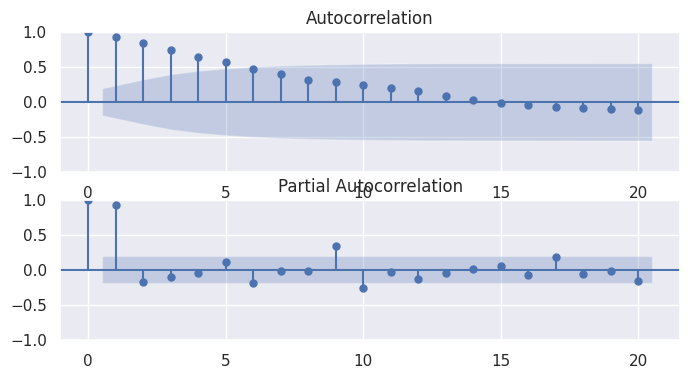

In [349]:
# Графики автокорреляции и частичной автокорреляции стоимости угля в $

plt.figure(figsize=(8, 4))
plt.subplot(211)
plot_acf(df_month['Coal'], lags=20, ax=plt.gca())

plt.subplot(212)
plot_pacf(df_month['Coal'], method='ywmle', lags=20, ax=plt.gca())

plt.show()

In [350]:
# dataframe со шкалированной стоимостью угля при разных ед изм.

df2

in_doll  in_gold  in_brent
Date                                  
2014-05-06  0.09148  0.32094   0.88053
2014-05-07  0.09073  0.31619   0.89545
2014-05-08  0.09148  0.31411   0.89025
2014-05-09  0.09148  0.31407   0.88877
2014-05-12  0.09135  0.31707   0.89464
...             ...      ...       ...
2022-10-12  0.60390  0.03974   0.06452
2022-10-13  0.58764  0.04319   0.07615
2022-10-14  0.59014  0.04011   0.06722
2022-10-17  0.57763  0.04424   0.07181
2022-10-18  0.57050  0.04511   0.07008

[1838 rows x 3 columns]

In [351]:
# делаю прореживание шкалированных данных и перехожу к среднемесячным значениям

df3 = df2.resample('M').mean()


df3

in_doll  in_gold  in_brent
Date                                  
2014-05-31  0.09119  0.31420   0.90559
2014-06-30  0.08516  0.32860   0.97099
2014-07-31  0.08607  0.33460   0.91916
2014-08-31  0.09649  0.30576   0.81497
2014-09-30  0.09193  0.29557   0.78975
...             ...      ...       ...
2022-06-30  0.74822  0.02702   0.07906
2022-07-31  0.86378  0.00393   0.02184
2022-08-31  0.79203  0.01550   0.02395
2022-09-30  0.75128  0.01508   0.01740
2022-10-31  0.59724  0.04250   0.06962

[102 rows x 3 columns]

### 08.1 Графики автокорреляции и частичной автокорреляции шкалированной стоимости угля
###### acf


[Ссылка на оглавление](######Start)

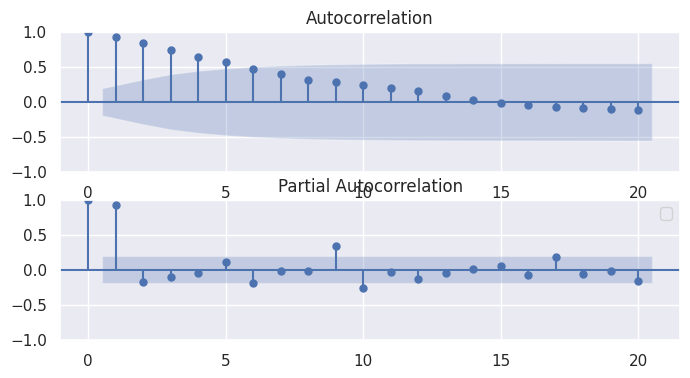

In [352]:
# Графики автокорреляции и частичной автокорреляции шкалированной стоимости угля в $

plt.figure(figsize=(8, 4))
plt.subplot(211)
plot_acf(df3['in_doll'], lags=20, ax=plt.gca())

plt.subplot(212)
plot_pacf(df3['in_doll'], method='ywmle', lags=20, ax=plt.gca())
plt.legend('')
plt.show()

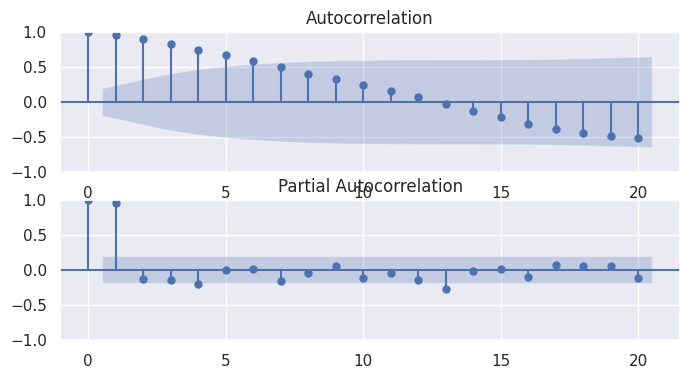

In [353]:
# Графики автокорреляции и частичной автокорреляции шкалированной стоимости угля в золоте

plt.figure(figsize=(8, 4))
plt.subplot(211)
plot_acf(df3['in_gold'], lags=20, ax=plt.gca())

plt.subplot(212)
plot_pacf(df3['in_gold'], method='ywmle', lags=20, ax=plt.gca())

plt.show()

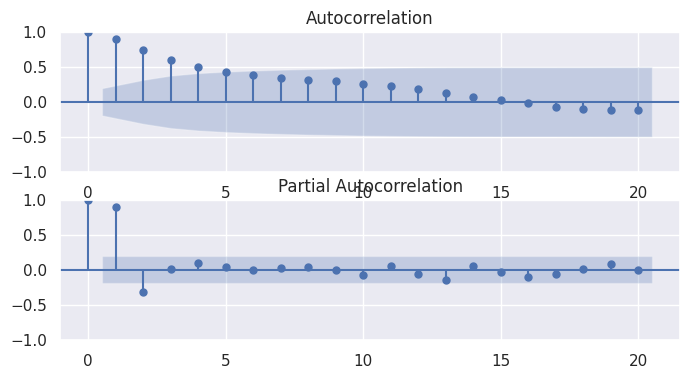

In [354]:
# Графики автокорреляции и частичной автокорреляции шкалированной стоимости угля в нефти

plt.figure(figsize=(8, 4))
plt.subplot(211)
plot_acf(df3['in_brent'], lags=20, ax=plt.gca())

plt.subplot(212)
plot_pacf(df3['in_brent'], method='ywmle', lags=20, ax=plt.gca())

plt.show()

In [355]:
# df_month

In [356]:
# df только по мес знач стоимости угля

df_month_coal = df_month['Coal']

df_month_coal

Date
2014-05-31     75.03611
2014-06-30     72.62333
2014-07-31     72.98722
2014-08-31     77.15263
2014-09-30     75.33150
                ...    
2022-06-30    337.69714
2022-07-31    383.89250
2022-08-31    355.21087
2022-09-30    338.91905
2022-10-31    277.33750
Freq: M, Name: Coal, Length: 102, dtype: float64

### 08.2 Графики компоненты: тренд, сезонность и шум
###### sm.tsa.seasonal_decompose

Данные графики представлены только для информации, но, на мой взляд, не несут существенного влияния на анализ временного ряда стоимости угля.

[Ссылка на оглавление](######Start)

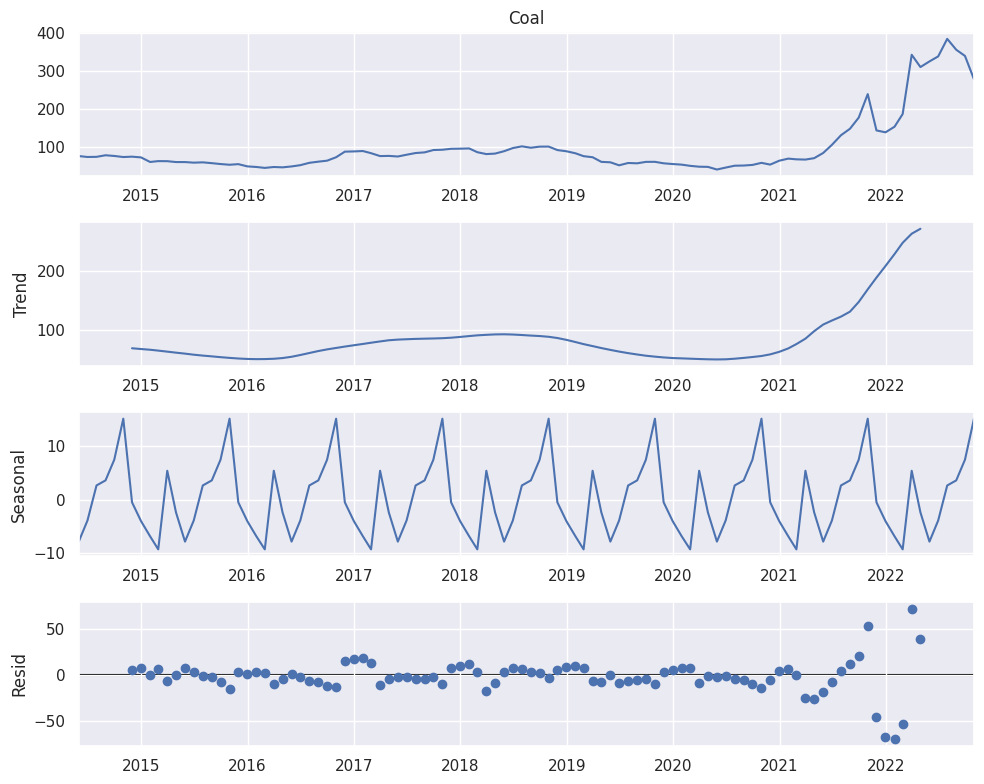

In [357]:
# Вычисляю компоненты: тренд, сезонность и шум

rcParams['figure.figsize'] = 10, 8
# decomposition = sm.tsa.seasonal_decompose(df_month_coal, model='additive')
decomposition = sm.tsa.seasonal_decompose(df_month['Coal'], model='additive')

fig = decomposition.plot()
plt.show()

In [358]:
# модель ARIMA
# (1, 0, 0)

model = sm.tsa.ARIMA(df_month_coal, order=(1, 0, 0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Coal   No. Observations:                  102
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -463.421
Date:                Wed, 19 Oct 2022   AIC                            932.842
Time:                        15:26:42   BIC                            940.717
Sample:                    05-31-2014   HQIC                           936.031
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        126.4880    123.434      1.025      0.305    -115.438     368.414
ar.L1          0.9683      0.035     27.742      0.000       0.900       1.037
sigma2       503.5457     23.711     21.237      0.000     457.073     550.018
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              2798.45
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              53.14   Skew:                             2.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

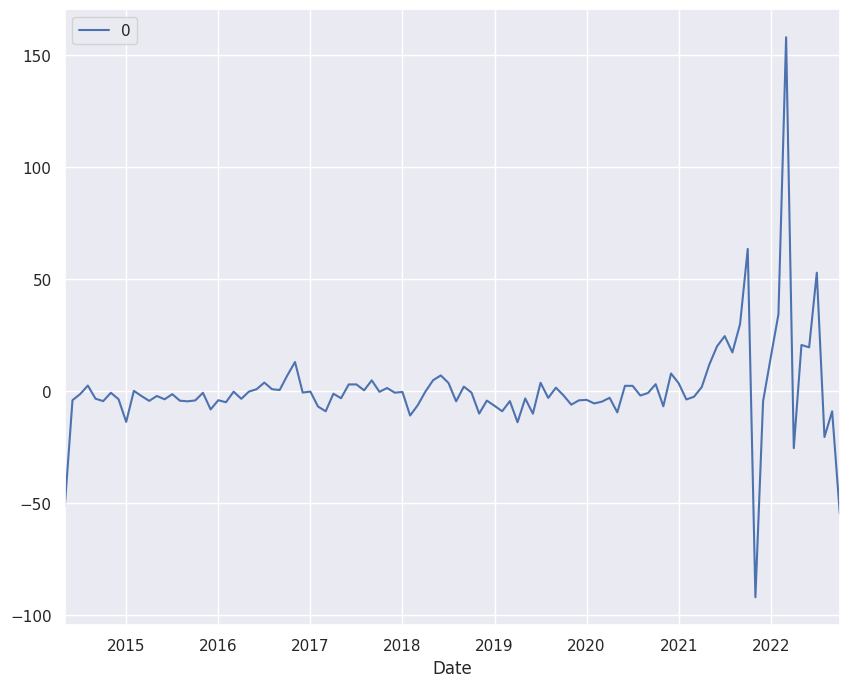

In [359]:
# остатки модели

residuals = pd.DataFrame(model_fit.resid)

residuals.plot()
plt.show()
print(residuals.describe())

In [360]:
# модель ARIMA
# (2, 0, 2)

model_2 = sm.tsa.ARIMA(df_month_coal, order=(2, 0, 2))
model_2_fit = model_2.fit()
model_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Coal   No. Observations:                  102
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -462.623
Date:                Wed, 19 Oct 2022   AIC                            937.247
Time:                        15:26:42   BIC                            952.996
Sample:                    05-31-2014   HQIC                           943.624
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        116.2643    111.002      1.047      0.295    -101.295     333.823
ar.L1          0.7586      0.313      2.423      0.015       0.145       1.372
ar.L2          0.1793      0.300      0.599      0.549      -0.408       0.766
ma.L1          0.2514      0.305      0.823      0.411      -0.347       0.850
ma.L2          0.1940      0.075      2.583      0.010       0.047       0.341
sigma2       495.9554     32.745     15.146      0.000     431.776     560.135
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2331.64
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              54.52   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

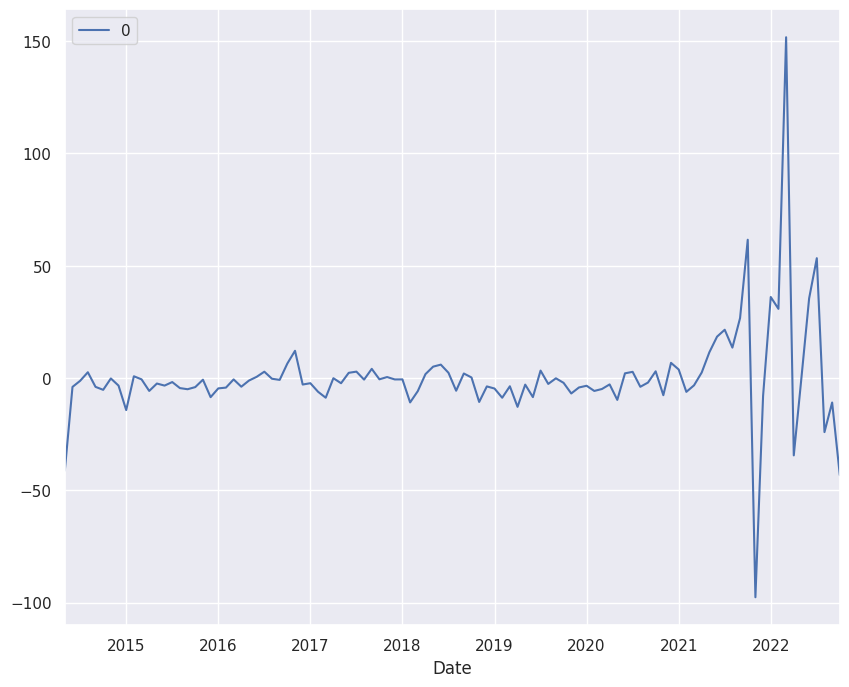

In [361]:
# остатки модели

residuals_2 = pd.DataFrame(model_2_fit.resid)

residuals_2.plot()
plt.show()
print(residuals_2.describe())
print('-----------')
print(residuals_2.info())
print('-----------')
print(residuals_2.tail())

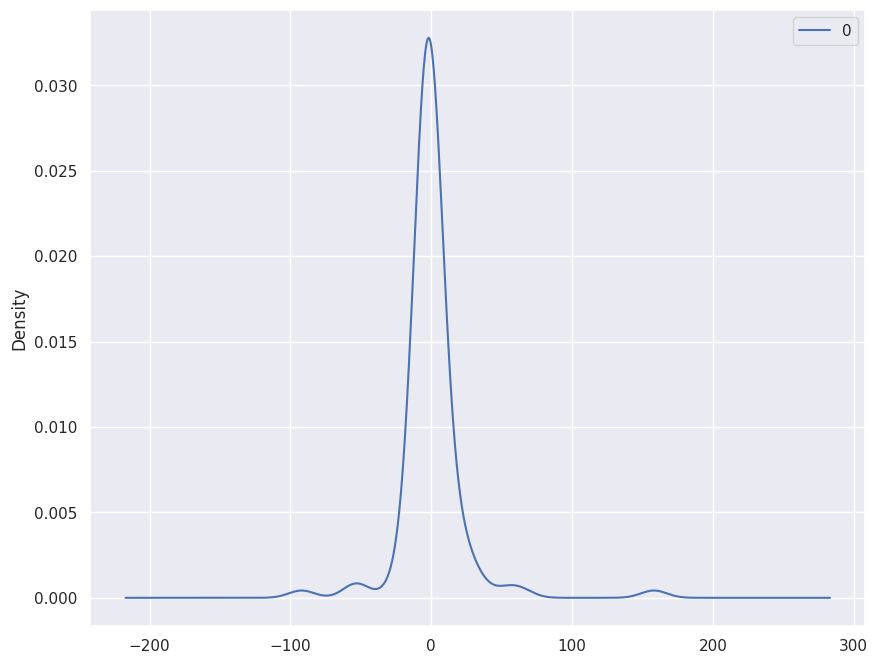

In [362]:
# ядерная оценка плотности остатков модели 

residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [363]:
# на основании модели строю прогноз на последние наблюдения

df_fit = model_fit.predict(0, 20)

df_fit

Date
2014-05-31    126.48797
2014-06-30     76.66949
2014-07-31     74.33331
2014-08-31     74.68564
2014-09-30     78.71882
2014-10-31     76.95550
2014-11-30     74.18392
2014-12-31     75.12234
2015-01-31     73.24079
2015-02-28     61.60365
2015-03-31     63.76813
2015-04-30     63.61102
2015-05-31     61.37939
2015-06-30     61.33611
2015-07-31     59.85274
2015-08-31     60.63654
2015-09-30     58.57250
2015-10-31     56.30280
2015-11-30     54.50023
2015-12-31     56.05266
2016-01-31     50.35916
Freq: M, Name: predicted_mean, dtype: float64

In [364]:
# прогноз на steps наблюдений вперед с доверительным интервалом 95%
df_fit_f = model_fit.forecast(steps=10, alpha=0.05)

df_fit_f

2022-11-30    272.54867
2022-12-31    267.91187
2023-01-31    263.42226
2023-02-28    259.07519
2023-03-31    254.86611
2023-04-30    250.79065
2023-05-31    246.84457
2023-06-30    243.02377
2023-07-31    239.32425
2023-08-31    235.74218
Freq: M, Name: predicted_mean, dtype: float64

<AxesSubplot: >

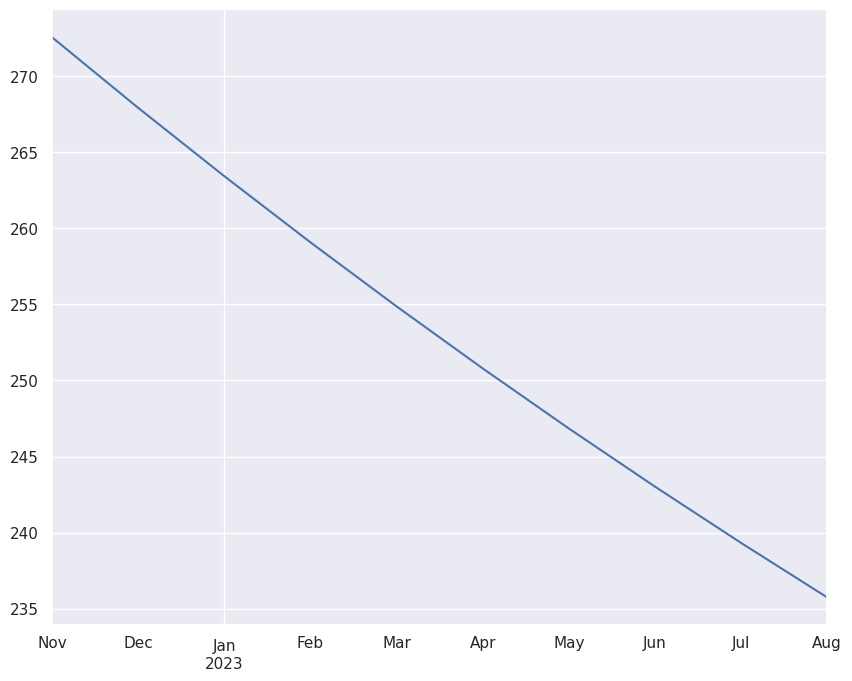

In [365]:
df_fit_f.plot()

### 08.3 Подбор параметров для модели временных рядов ARIMA для прогнозирования стоимости угля в $
###### sm.tsa.statespace.SARIMAX


[Ссылка на оглавление](######Start)

In [366]:


p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
###
print('SARIMAX: {} x {}'.format(pdq[4], seasonal_pdq[4]))

In [367]:
# анализ вышепредст формул

print('p :', p)
print('d :', d)
print('q :', q)
print('pdq :', pdq)
print('-----')
print('seasonal_pdq :', seasonal_pdq)
print('--------')

In [368]:
# Этот шаг - выбор параметров для модели временных рядов ARIMA для стоимости угля. 
# Наша цель здесь - использовать “поиск по сетке”, чтобы найти оптимальный набор параметров, 
# который обеспечивает наилучшую производительность для нашей модели.

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_month_coal,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        except:
            continue

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

In [369]:
# вот что оптимально подобрало:
# CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:645.3988654229423

# 2022-10-18:
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:645.5164241222554

# 2022-10-18:
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:713.4371806842479

### 08.4 Обучение модели временных рядов ARIMA для стоимости угля в $
###### mod.fit


[Ссылка на оглавление](######Start)

In [370]:
# Fitting the ARIMA model

mod = sm.tsa.statespace.SARIMAX(df_month_coal,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
# print(results.summary())
print('--------')

 This problem is unconstrained.


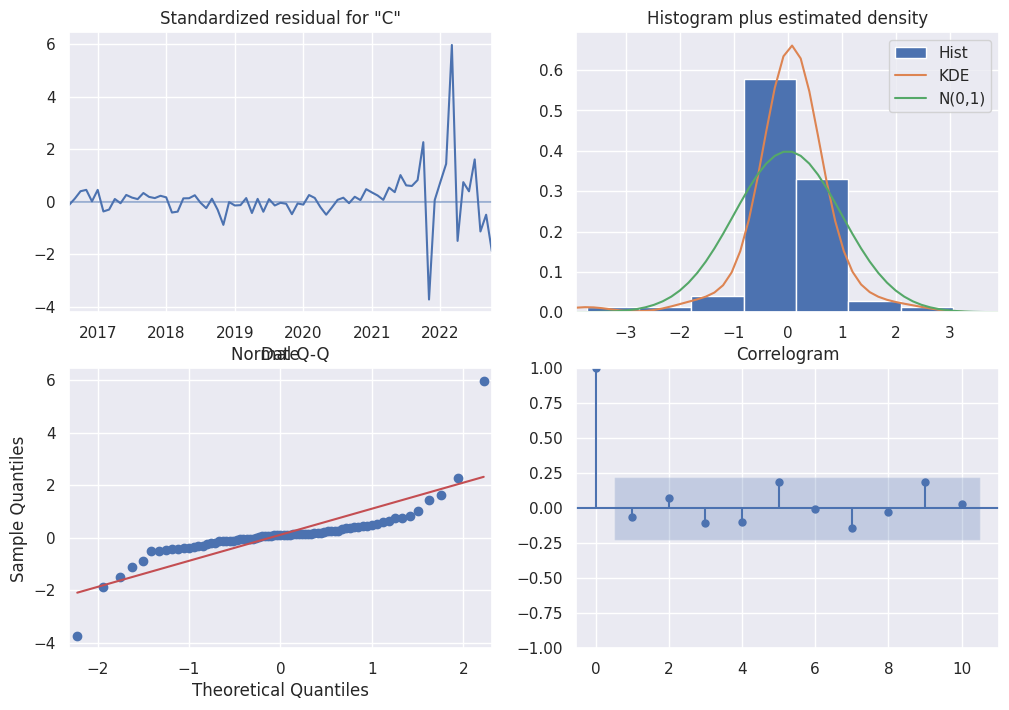

In [371]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

In [372]:
# последние фактические значения

df_month_coal.tail(10)

Date
2022-01-31    152.33200
2022-02-28    185.79210
2022-03-31    341.98478
2022-04-30    309.64250
2022-05-31    324.42953
2022-06-30    337.69714
2022-07-31    383.89250
2022-08-31    355.21087
2022-09-30    338.91905
2022-10-31    277.33750
Freq: M, Name: Coal, dtype: float64

In [373]:
# прогноз на steps наблюдений вперед с доверительным интервалом 95%
df_coal_forecast = results.forecast(steps=10, alpha=0.05)

df_coal_forecast

2022-11-30    299.36665
2022-12-31    308.98258
2023-01-31    308.11043
2023-02-28    293.66892
2023-03-31    243.10893
2023-04-30    255.51239
2023-05-31    262.37254
2023-06-30    279.93924
2023-07-31    291.89387
2023-08-31    317.54590
Freq: M, Name: predicted_mean, dtype: float64

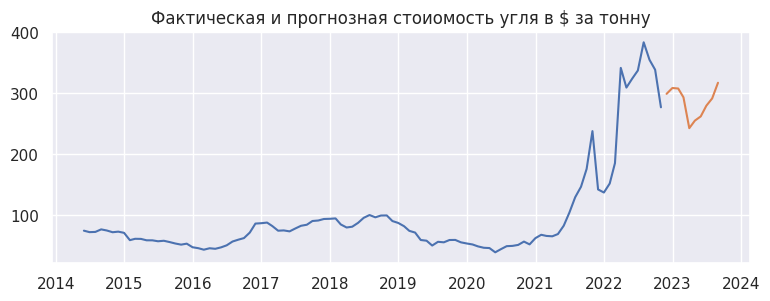

In [374]:
### соед графики

plt.figure(figsize=(9, 3))
plt.plot(df_month_coal, label='Факт')
plt.plot(df_coal_forecast, label='Прогноз')
plt.title('Фактическая и прогнозная стоиомость угля в $ за тонну')
plt.show()

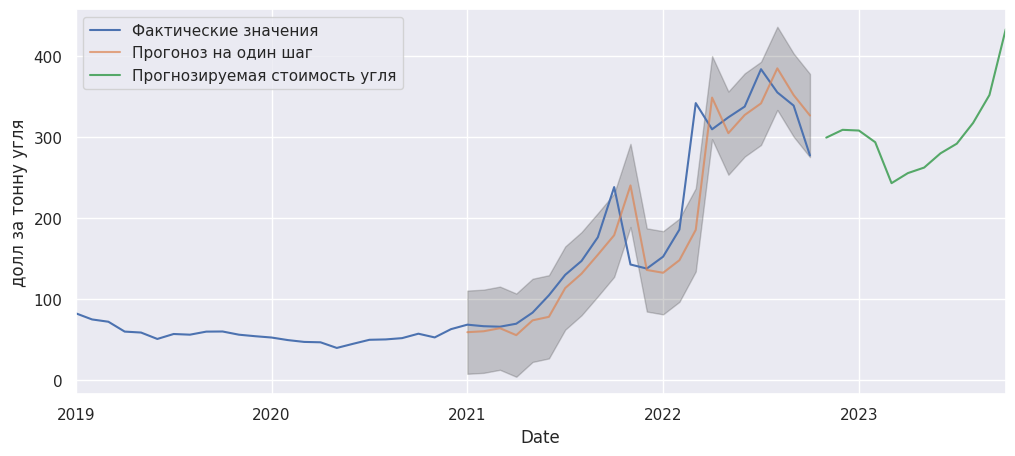

<Figure size 1200x600 with 0 Axes>

In [375]:
forecast = results.forecast(steps=12, alpha=0.05)

pred = results.get_prediction(start=pd.to_datetime('2021-01-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = df_month_coal['2019':].plot(label='Фактические значения')
pred.predicted_mean.plot(ax=ax, label='Прогоноз на один шаг', alpha=.7, figsize=(12, 5)) #  alpha=.7
forecast.plot(ax=ax, label='Прогнозируемая стоимость угля')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('долл за тонну угля')
plt.legend()
plt.figure(figsize=(12, 6))
plt.show()

### 09 Построение прогнозов стоимости угля на основании использования библиотеки SKTIME
###### sktime


[Ссылка на оглавление](######Start)

#### 09.1 Метод прогнозирования VAR

###### sktime.var

In [376]:
y = df_month[['Coal', 'Brent', 'Gold']]

# y2 = df_month['Coal']

y

Coal      Brent        Gold
Date                                        
2014-05-31   75.03611  109.41889  1285.75556
2014-06-30   72.62333  112.26222  1286.80555
2014-07-31   72.98722  107.75722  1311.15000
2014-08-31   77.15263  103.13053  1295.52106
2014-09-30   75.33150   98.14950  1233.70000
...               ...        ...         ...
2022-06-30  337.69714  117.66381  1834.54762
2022-07-31  383.89250  104.70500  1729.80000
2022-08-31  355.21087   97.74087  1762.47826
2022-09-30  338.91905   90.32476  1678.61429
2022-10-31  277.33750   93.09583  1680.96666

[102 rows x 3 columns]

In [377]:
forecaster = VAR()
forecaster.fit(y, fh=[1, 2, 3, 4, 5, 6])

y_pred = forecaster.predict()

In [378]:
y_pred

Coal     Brent        Gold
2022-11-30  273.59694  92.55657  1661.81237
2022-12-31  269.63352  91.93975  1643.08763
2023-01-31  265.46147  91.25377  1624.83691
2023-02-28  261.09677  90.50663  1607.10078
2023-03-31  256.55680  89.70589  1589.91591
2023-04-30  251.85996  88.85876  1573.31511

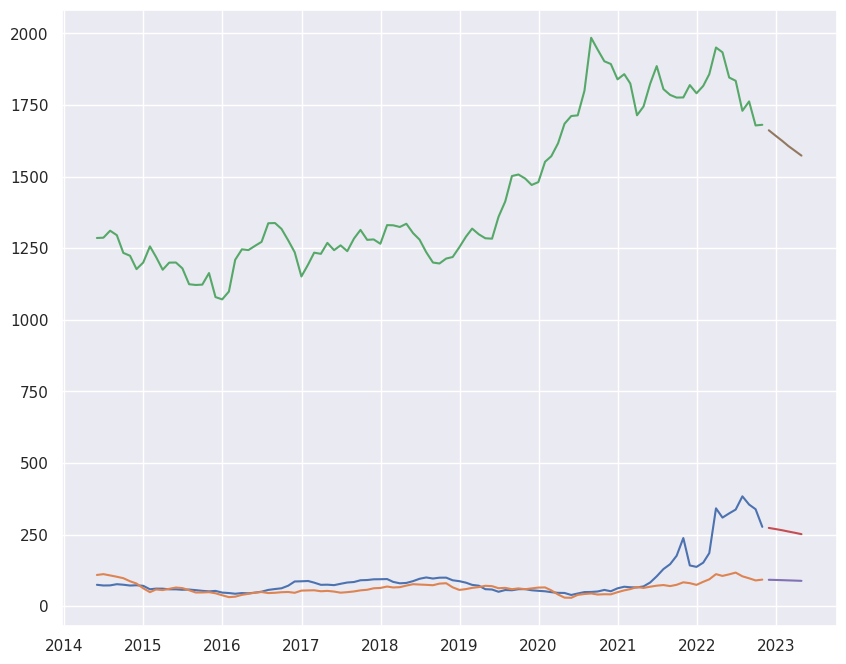

In [379]:
# График
plt.plot(y)
plt.plot(y_pred)
plt.show()

In [455]:
# Опять шкалирую
from sklearn.preprocessing import MinMaxScaler


In [450]:
# dataframe со стоимостью угля при разных ед изм.
df4 = pd.concat([df['Coal'], df_gold['Coal'], df_brent['Coal']], axis=1)

df4.columns = ['in_doll', 'in_gold', 'in_brent']

df4

in_doll   in_gold  in_brent
Date                                     
2014-05-06   75.15000  17.40918   1.42462
2014-05-07   74.85000  17.21576   1.44462
2014-05-08   75.15000  17.13107   1.43766
2014-05-09   75.15000  17.12974   1.43566
2014-05-12   75.10000  17.25166   1.44354
...               ...       ...       ...
2022-10-12  280.00000   5.96536   0.33018
2022-10-13  273.50000   6.10603   0.34578
2022-10-14  274.50000   5.98069   0.33381
2022-10-17  269.50000   6.14842   0.33996
2022-10-18  266.64999   6.18414   0.33763

[1838 rows x 3 columns]

In [443]:

scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))



MinMaxScaler()

In [451]:
df4_scaled = scaler.fit(df4).transform(df4)

df4_scaled

array([[0.0914776 , 0.32094103, 0.88053154],
       [0.09072716, 0.31618828, 0.89544744],
       [0.0914776 , 0.31410714, 0.89025465],
       ...,
       [0.59013932, 0.04011411, 0.06722234],
       [0.57763213, 0.04423568, 0.07181225],
       [0.57050301, 0.04511326, 0.07007552]])

In [452]:
# Series с востановленными значениями
series_inv = scaler.inverse_transform(df4_scaled)

series_inv

array([[ 75.15000153,  17.40918193,   1.42461737],
       [ 74.84999847,  17.21576489,   1.44462257],
       [ 75.15000153,  17.13107117,   1.437658  ],
       ...,
       [274.5       ,   5.98069199,   0.33380691],
       [269.5       ,   6.14842301,   0.3399629 ],
       [266.6499939 ,   6.18413665,   0.33763361]])

In [454]:

# df с востановленими значениями
df4_inv = pd.DataFrame(series_inv, index=df.index)

df4_inv.columns = ['in_doll', 'in_gold', 'in_brent']

df4_inv

in_doll   in_gold  in_brent
Date                                     
2014-05-06   75.15000  17.40918   1.42462
2014-05-07   74.85000  17.21576   1.44462
2014-05-08   75.15000  17.13107   1.43766
2014-05-09   75.15000  17.12974   1.43566
2014-05-12   75.10000  17.25166   1.44354
...               ...       ...       ...
2022-10-12  280.00000   5.96536   0.33018
2022-10-13  273.50000   6.10603   0.34578
2022-10-14  274.50000   5.98069   0.33381
2022-10-17  269.50000   6.14842   0.33996
2022-10-18  266.64999   6.18414   0.33763

[1838 rows x 3 columns]

In [457]:
# шкалированныe данные стоимости угля в разных ед.измерения

y = df4_scaled

y

array([[0.0914776 , 0.32094103, 0.88053154],
       [0.09072716, 0.31618828, 0.89544744],
       [0.0914776 , 0.31410714, 0.89025465],
       ...,
       [0.59013932, 0.04011411, 0.06722234],
       [0.57763213, 0.04423568, 0.07181225],
       [0.57050301, 0.04511326, 0.07007552]])

In [470]:
# Прогнозирование
forecaster = VAR()
# forecaster = VARMAX()

fh = np.arange(1, 1000)
forecaster.fit(y, fh=fh)

y_pred = forecaster.predict()

# прогноз в шкалированных значениях
y_pred

array([[0.56960692, 0.04510518, 0.07063292],
       [0.56871581, 0.04509873, 0.07118931],
       [0.56782964, 0.04509389, 0.07174467],
       ...,
       [0.33719529, 0.16026772, 0.25709261],
       [0.33713646, 0.16033778, 0.25713672],
       [0.33707774, 0.16040773, 0.25718075]])

In [471]:
# Series с востановленными значениями
series_pred_inv = scaler.inverse_transform(y_pred)

series_pred_inv

array([[266.29176232,   6.18380796,   0.33838119],
       [265.93552274,   6.18354541,   0.33912741],
       [265.5812598 ,   6.18334847,   0.33987227],
       ...,
       [173.3805636 ,  10.87044518,   0.58846095],
       [173.35704614,  10.87329636,   0.58852012],
       [173.33356944,  10.87614308,   0.58857917]])

In [472]:
# df прогнозными значениями 
df4_pred_inv = pd.DataFrame(series_pred_inv)

df4_pred_inv.columns = ['in_doll', 'in_gold', 'in_brent']

df4_pred_inv

in_doll   in_gold  in_brent
0    266.29176   6.18381   0.33838
1    265.93552   6.18355   0.33913
2    265.58126   6.18335   0.33987
3    265.22896   6.18322   0.34062
4    264.87860   6.18315   0.34136
..         ...       ...       ...
994  173.42772  10.86473   0.58834
995  173.40412  10.86759   0.58840
996  173.38056  10.87045   0.58846
997  173.35705  10.87330   0.58852
998  173.33357  10.87614   0.58858

[999 rows x 3 columns]

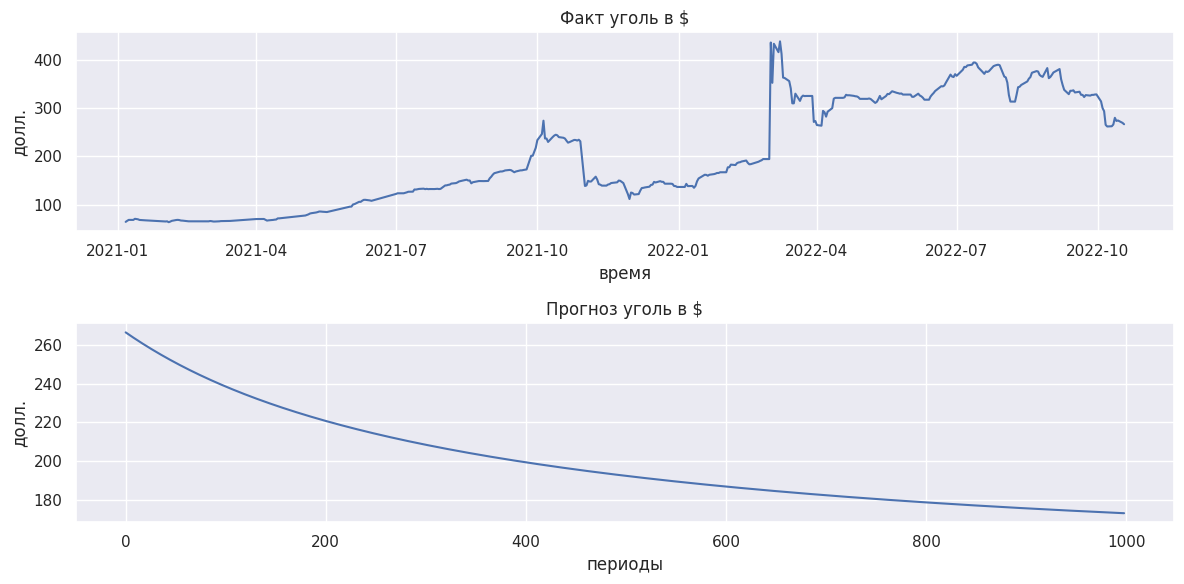

In [499]:
# fig, axs = plt.subplots(2, 1)

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(12, 6))

axs[0].set_title('Факт уголь в $')
axs[0].plot(df4['in_doll']['2021-01-01':])
axs[0].set_xlabel('время')
axs[0].set_ylabel('долл.')
axs[1].set_title('Прогноз уголь в $')
axs[1].plot(df4_pred_inv['in_doll'])
axs[1].set_xlabel('периоды')
axs[1].set_ylabel('долл.')

fig.tight_layout()
plt.show()

In [416]:
# полный список многомерных прогнозов

# for forecaster in all_estimators(filter_tags={"scitype:y": ["multivariate", "both"]}):
#     print(forecaster[0])

# Вот так все показывает:
# all_estimators()

#### 09.2 Метод прогнозирования ARIMA

###### sktime.arima

In [ ]:
# Прогнозирование с использованием sktime ARIMA

In [410]:
# Расчет прогноза по самому временному ряду стоимости угля
y = df_month['Coal'] # месячные данные

# y = df_day['Coal'] # ежедневные данные

y

Date
2014-05-31     75.03611
2014-06-30     72.62333
2014-07-31     72.98722
2014-08-31     77.15263
2014-09-30     75.33150
                ...    
2022-06-30    337.69714
2022-07-31    383.89250
2022-08-31    355.21087
2022-09-30    338.91905
2022-10-31    277.33750
Freq: M, Name: Coal, Length: 102, dtype: float64

In [411]:
# задание периодов прогноза

fh = np.arange(1, 10)

fh

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [414]:

forecaster = ARIMA()

# или так можно задать:
# forecaster.fit(y, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

forecaster.fit(y, fh=fh)

y_pred_ARIMA = forecaster.predict()

y_pred_ARIMA

2022-11-30    272.55329
2022-12-31    267.92085
2023-01-31    263.43537
2023-02-28    259.09219
2023-03-31    254.88679
2023-04-30    250.81479
2023-05-31    246.87198
2023-06-30    243.05424
2023-07-31    239.35762
dtype: float64

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Coal'>)

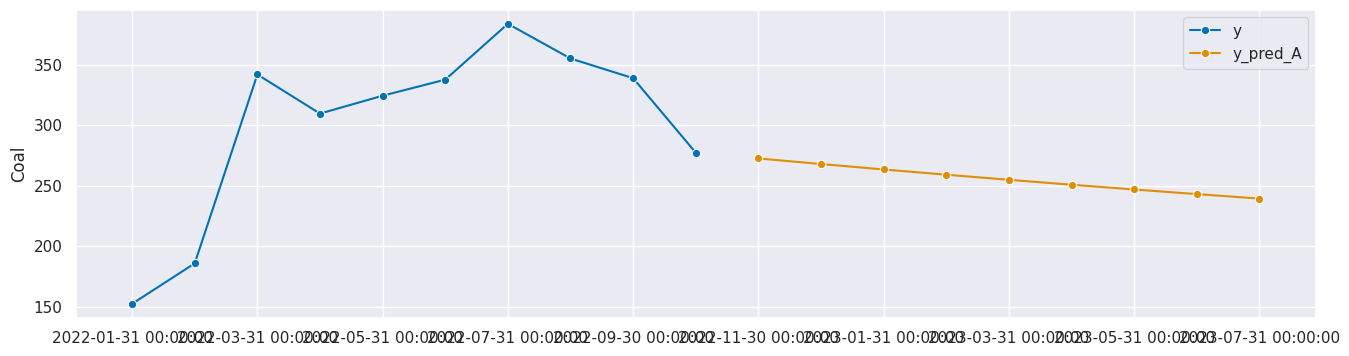

In [415]:
plot_series(y['2022-01-01':], y_pred_A, labels=["y", "y_pred_A"])

In [388]:
# forecaster.forecasters_

In [389]:
# вероятностный прогноз
coverage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints

Coverage           
                  0.9           
                lower      upper
2022-11-30  235.64413  309.46245
2022-12-31  216.54469  319.29701
2023-01-31  201.49199  325.37876
2023-02-28  188.66716  329.51722
2023-03-31  177.34786  332.42571
2023-04-30  167.15381  334.47578
2023-05-31  157.85280  335.89115
2023-06-30  149.28914  336.81934
2023-07-31  141.35145  337.36378

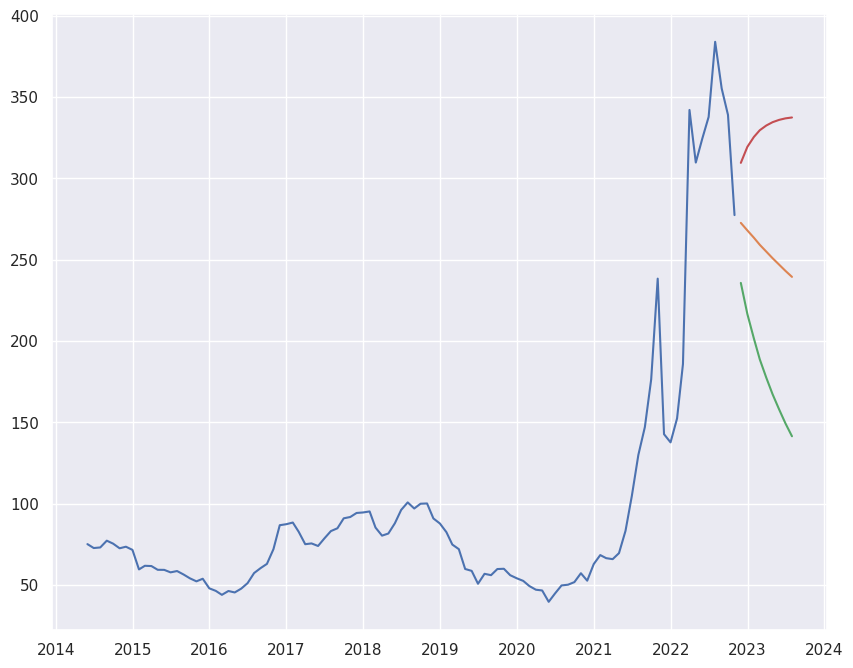

<Figure size 600x400 with 0 Axes>

In [392]:
plt.plot(y)
plt.plot(y_pred_A)
plt.plot(y_pred_ints)
plt.figure(figsize=(6, 4))
plt.show()

In [205]:
# или так:
y_pred_ints_1 = forecaster.predict_interval(coverage=0.95)
y_pred_ints_1

Coverage           
                 0.95           
                lower      upper
2022-11-30  228.57332  316.53326
2022-12-31  206.70238  329.13932
2023-01-31  189.62528  337.24547
2023-02-28  175.17559  343.00879
2023-03-31  162.49346  347.28012
2023-04-30  151.12658  350.50300
2023-05-31  140.79909  352.94487
2023-06-30  131.32623  354.78225
2023-07-31  122.57607  356.13917

predict_quantiles - квантильные прогнозы
sktime предлагает predict_quantiles в качестве унифицированного интерфейса для возврата квантильных значений прогнозов. Аналогично predict_interval.

predict_quantiles имеет аргумент alpha, содержащий запрашиваемые значения квантилей. Подобно случаю с predict_interval, alpha может быть значением с плавающей точкой или списком значений с плавающей точкой.

In [206]:
y_pred_quantiles = forecaster.predict_quantiles(alpha=[0.275, 0.975])
y_pred_quantiles

Quantiles           
                0.275      0.975
2022-11-30  259.14005  316.53326
2022-12-31  249.25012  329.13932
2023-01-31  240.92438  337.24547
2023-02-28  233.49886  343.00879
2023-03-31  226.70818  347.28012
2023-04-30  220.41136  350.50300
2023-05-31  214.52131  352.94487
2023-06-30  208.97885  354.78225
2023-07-31  203.74097  356.13917

In [207]:
# predict_var выдает предсказания дисперсии:
y_pred_var = forecaster.predict_var()
y_pred_var

0
2022-11-30   503.51657
2022-12-31   975.59324
2023-01-31  1418.19312
2023-02-28  1833.15678
2023-03-31  2222.20982
2023-04-30  2586.97014
2023-05-31  2928.95458
2023-06-30  3249.58529
2023-07-31  3550.19560

In [208]:
# predict_proba - прогнозы распределения
y_pred_proba = forecaster.predict_proba()
y_pred_proba

<tfp.distributions.Normal 'Normal' batch_shape=[9, 1] event_shape=[] dtype=float32>

In [210]:
# ARIMA 
fh = [1, 2, 3]

forecaster = ARIMA()
forecaster.fit(y, fh=fh)
forecaster.predict()

2022-11-30    272.55329
2022-12-31    267.92085
2023-01-31    263.43537
dtype: float64

In [259]:
forecaster.predict().plot()

ValueError: Must supply freq for datetime value

In [212]:
# forecaster.forecasters_

In [213]:
# работаю с ежедневными данными по стоимости угля
y = pd.Series(df['Coal']['2018-01-01':])

y

Date
2018-01-02     94.50000
2018-01-03     94.50000
2018-01-04     96.10000
2018-01-05     96.40000
2018-01-08     96.40000
                ...    
2022-10-12    280.00000
2022-10-13    273.50000
2022-10-14    274.50000
2022-10-17    269.50000
2022-10-18    266.64999
Name: Coal, Length: 1013, dtype: float64

In [214]:
# Шаг 1 - Разделение набора исторических данных на временную последовательность и тестовый пакет

y_train, y_test = temporal_train_test_split(y, test_size=36)

In [215]:
y_train

Date
2018-01-02     94.50000
2018-01-03     94.50000
2018-01-04     96.10000
2018-01-05     96.40000
2018-01-08     96.40000
                ...    
2022-08-22    376.75000
2022-08-23    376.00000
2022-08-24    369.00000
2022-08-25    366.35001
2022-08-26    364.85001
Name: Coal, Length: 977, dtype: float64

In [216]:
y_test

Date
2022-08-29    383.00000
2022-08-30    362.10001
2022-08-31    364.54999
2022-09-01    369.00000
2022-09-02    373.89999
2022-09-06    381.00000
2022-09-07    360.00000
2022-09-08    348.00000
2022-09-09    338.00000
2022-09-12    329.00000
2022-09-13    336.00000
2022-09-14    336.00000
2022-09-15    337.00000
2022-09-16    332.50000
2022-09-19    334.00000
2022-09-20    327.64999
2022-09-21    327.50000
2022-09-22    323.00000
2022-09-23    327.00000
2022-09-26    326.00000
2022-09-27    327.50000
2022-09-28    327.50000
2022-09-29    328.25000
2022-09-30    328.50000
2022-10-03    314.00000
2022-10-04    300.00000
2022-10-05    293.75000
2022-10-06    265.50000
2022-10-07    262.00000
2022-10-10    262.50000
2022-10-11    266.14999
2022-10-12    280.00000
2022-10-13    273.50000
2022-10-14    274.50000
2022-10-17    269.50000
2022-10-18    266.64999
Name: Coal, dtype: float64

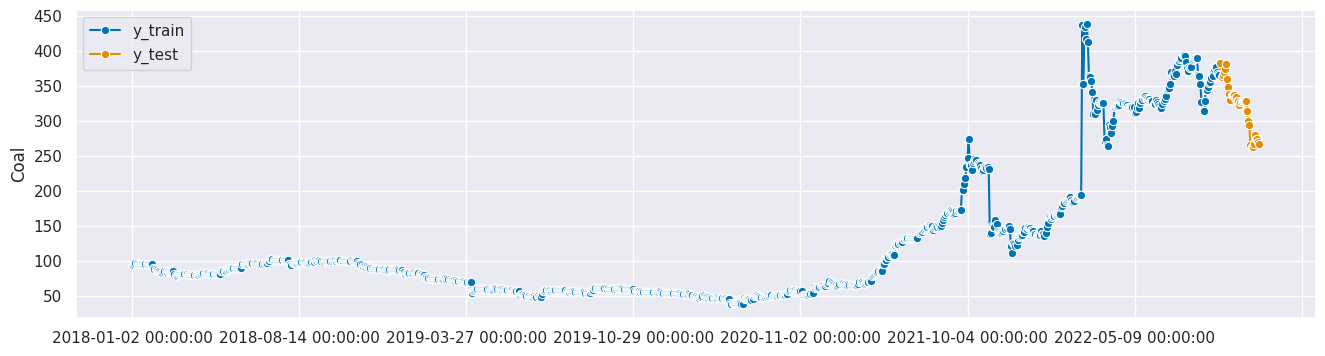

In [217]:
# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])



In [251]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

fh

ForecastingHorizon(['2022-08-29', '2022-08-30', '2022-08-31', '2022-09-01',
               '2022-09-02', '2022-09-06', '2022-09-07', '2022-09-08',
               '2022-09-09', '2022-09-12', '2022-09-13', '2022-09-14',
               '2022-09-15', '2022-09-16', '2022-09-19', '2022-09-20',
               '2022-09-21', '2022-09-22', '2022-09-23', '2022-09-26',
               '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30',
               '2022-10-03', '2022-10-04', '2022-10-05', '2022-10-06',
               '2022-10-07', '2022-10-10', '2022-10-11', '2022-10-12',
               '2022-10-13', '2022-10-14', '2022-10-17', '2022-10-18'],
              dtype='datetime64[ns]', freq=None, is_relative=False)

In [252]:
# https://habr.com/ru/company/sbermegamarket/blog/692392/?ysclid=l9emd5p9ns954431029



#### Finish


[Ссылка на оглавление](######Start)